Authors

* Andrea Bonomi (a.bonomi021@studenti.unibs.it)
* Giorgio Bucella (g.bucella002@studenti.unibs.it)
* Riccardo Rossi-Erba (r.rossierba@studenti.unibs.it)

# Introduction

The project began with an in-depth study of the **Mamba architecture**, a language model based not on transformers — the industry-standard approach — but on **State Space Models** (SSMs). While transformers remain the dominant paradigm, alternative architectures like Mamba demonstrate that efficiency and scalability can also be achieved through different design principles. These advances are not confined to academic research: recent commercial applications, such as **Mistral's Codestral**, show that Mamba-based models are already being deployed for specialized tasks like code generation, underlining the growing relevance of non-transformer approaches. After reviewing Mamba 2, the most efficient implementation of this architecture, the research focused on evaluating its performance in a constrained computational environment (specifically Google Colab), starting with the smallest available model versions. Using the original reference paper as a foundation, the study centered on implementing and assessing different fine-tuning techniques for the Mamba model across various scales, within the limits of the available resources, in order to compare our results with those presented in the paper.



Once the environment was properly set up, initial configurations were defined, including the tokenizer and evaluation metrics (LM-eval), to ensure a consistent and reliable comparison with the reference benchmarks. To enhance reproducibility and maintain clarity in parameter selection, dedicated functions were developed for fine-tuning procedures. The experiments focused on two datasets — **PiQA** and **ARC-e** —and employed two main fine-tuning strategies: Supervised Fine-Tuning (**SFT**) and Direct Preference Optimization (**DPO**), along with an implementation of the LoRA technique. All experiments were conducted using the Hugging Face platform, which provided the necessary tools and infrastructure to manage models, datasets, and training workflows efficiently.

 At the end of the presentation,
the results of the fine-tuned models will be shown and compared with the results of the larger models on the same datasets.

# Preliminary operations

## Install libraries

We use Google Drive as our main storage space, as it is easy and convenient to connect to the Colab development environment.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

The Colab development environment gave us some initial problems with installing libraries.

After trying a few configurations, we found one that allowed us to install what we needed and get it working without any major incompatibility issues.

The versions that worked for our development environment are listed in the cell below.

In [ ]:
!pip install --upgrade pip

!pip install torch==2.7.1 torchvision==0.22.1 torchaudio==2.7.1 --index-url https://download.pytorch.org/whl/cu118
!pip install transformers==4.55.0

# working libraries with Python 3.12, cuda 12.4 in the colab environment
# other environments were not tested
!wget https://github.com/Dao-AILab/causal-conv1d/releases/download/v1.5.2/causal_conv1d-1.5.2+cu11torch2.7cxx11abiTRUE-cp312-cp312-linux_x86_64.whl
!wget https://github.com/state-spaces/mamba/releases/download/v2.2.5/mamba_ssm-2.2.5+cu11torch2.7cxx11abiTRUE-cp312-cp312-linux_x86_64.whl

!pip install /content/causal_conv1d-1.5.2+cu11torch2.7cxx11abiTRUE-cp312-cp312-linux_x86_64.whl
!pip install /content/mamba_ssm-2.2.5+cu11torch2.7cxx11abiTRUE-cp312-cp312-linux_x86_64.whl

The following libraries, on the other hand, did not cause any incompatibility issues and it was not necessary to “fix” the versions.

In [ ]:
!pip install lm-eval
!pip install trl
!pip install wandb

For training logs we use [Weight&Bias](https://wandb.ai/site/) (wandb).

In [ ]:
import torch
import wandb

device = "cuda" if torch.cuda.is_available() else "cpu"
wandb.login()

## Set up the Tokenizer


The tokenizer used is based on the pre-trained  [GPT-NeoX-20B](https://huggingface.co/docs/transformers/model_doc/gpt_neox) model, with 20 billion parameters. This tokenizer is common to all models.

We used this tokenizer because it is the one used by the Mamba authors to evaluate the models.
This [script](https://github.com/state-spaces/mamba/blob/main/evals/lm_harness_eval.py) shows the use of the tokenizer `"EleutherAI/gpt-neox-20b"`.


In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neox-20b")
tokenizer.pad_token_id = tokenizer.eos_token_id

## Result analysis functions

In [ ]:
from lm_eval import evaluator
from lm_eval.models.huggingface import HFLM
import matplotlib.pyplot as plt
import pandas as pd
from datetime import timedelta

### Plotting and Printing fine tuning log

These functions provide tools to retrieve, clean, and visualize training data from Weights & Biases (W\&B) runs afterwards, once the run is finished.

`print_run_duration` reports the total runtime of an experiment.
`get_sft_train_df` and `get_dpo_train_df` extract and organize training/evaluation histories for supervised fine-tuning (SFT) and direct preference optimization (DPO).

`plot_sft_results` and `plot_dpo_results` generate plots of loss curves (and accuracy for DPO), offering a quick view of training dynamics. Finally, `print_sft_table` and `print_dpo_table` display aligned training and evaluation metrics in markdown tables alongside runtime. Altogether, they simplify performance tracking and comparison across fine-tuning runs.

In [ ]:
wandb_user = 'r-rossierba-universit-degli-studi-di-brescia'
wandb_project = 'mamba2'

In [ ]:
def print_run_duration(wandb_run_id):
    api = wandb.Api()
    run = api.run(f'{wandb_user}/{wandb_project}/{wandb_run_id}')
    runtime_seconds = run.summary.get("_runtime", None)

    print(f'Run duration: {str(timedelta(seconds=runtime_seconds))}')

In [ ]:
def get_sft_train_df(wandb_run_id):
  wandb_run_name = f'r-rossierba-universit-degli-studi-di-brescia/mamba2/{wandb_run_id}'
  api = wandb.Api()
  run = api.run(wandb_run_name)
  history = run.history()

  # clean the dataframes
  eval_loss_history = history[history['eval/loss'].notna()]
  eval_loss_history = eval_loss_history.drop(columns=[col for col in eval_loss_history.columns if col not in ['eval/loss', 'train/global_step', 'train/epoch']])

  train_loss_history = history[history['train/loss'].notna()]
  train_loss_history = train_loss_history.drop(columns=[col for col in train_loss_history.columns if col not in ['train/loss', 'train/global_step']])

  return eval_loss_history, train_loss_history

def plot_sft_results(wandb_run_id):
  eval_loss_history, train_loss_history = get_sft_train_df(wandb_run_id)

  fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True)

  axes[0].plot(eval_loss_history['train/global_step'], eval_loss_history['eval/loss'], label='Eval Loss', color='orange')
  axes[0].set_title('Eval Loss')
  axes[0].legend()

  axes[1].plot(train_loss_history['train/global_step'], train_loss_history['train/loss'], label='Train Loss', color='red')
  axes[1].set_title('Train Loss')
  axes[1].legend()

  for ax in axes.flat:
      ax.set_xlabel('Global Step')
      ax.grid(True)

  plt.tight_layout()
  plt.show()

def print_sft_table(wandb_run_id):
  print(f'Run id: {wandb_run_id}\n')
  eval_loss_history, train_loss_history = get_sft_train_df(wandb_run_id)
  train_loss_history = train_loss_history[train_loss_history['train/global_step'].isin(eval_loss_history['train/global_step'])]
  merged_df = pd.merge(train_loss_history, eval_loss_history, on='train/global_step')
  merged_df = merged_df[['train/epoch','train/global_step', 'train/loss', 'eval/loss']]
  merged_df.columns = ['Epoch', 'Step', 'Train Loss', 'Eval Loss']
  merged_df = merged_df.round(4)
  print_run_duration(wandb_run_id)
  print(merged_df.to_markdown(index=False))

In [ ]:
def get_dpo_train_df(wandb_run_id):
  wandb_run_name = f'r-rossierba-universit-degli-studi-di-brescia/mamba2/{wandb_run_id}'
  api = wandb.Api()
  run = api.run(wandb_run_name)
  history = run.history()

  # clean the dataframes
  eval_loss_history = history[history['eval/loss'].notna()]
  eval_loss_history = eval_loss_history.drop(columns=[col for col in eval_loss_history.columns if col not in ['eval/loss', 'train/global_step', 'train/epoch', 'eval/rewards/accuracies']])

  train_loss_history = history[history['train/loss'].notna()]
  train_loss_history = train_loss_history.drop(columns=[col for col in train_loss_history.columns if col not in ['train/loss', 'train/global_step']])

  return eval_loss_history, train_loss_history

def plot_dpo_results(wandb_run_id):
  eval_loss_history, train_loss_history = get_dpo_train_df(wandb_run_id)

  fig, axes = plt.subplots(1, 3, figsize=(12, 6), sharex=True)

  axes[0].plot(eval_loss_history['train/global_step'], eval_loss_history['eval/loss'], label='Eval Loss', color='orange')
  axes[0].set_title('Eval Loss')
  axes[0].legend()

  axes[1].plot(train_loss_history['train/global_step'], train_loss_history['train/loss'], label='Train Loss', color='red')
  axes[1].set_title('Train Loss')
  axes[1].legend()

  axes[2].plot(eval_loss_history['train/global_step'], eval_loss_history['eval/rewards/accuracies'], label='Accuracy', color='green')
  axes[2].set_title('Accuracy')
  axes[2].legend()

  for ax in axes.flat:
      ax.set_xlabel('Global Step')
      ax.grid(True)

  plt.tight_layout()
  plt.show()

def print_dpo_table(wandb_run_id):
  print(f'Run id: {wandb_run_id}\n')
  eval_loss_history, train_loss_history = get_dpo_train_df(wandb_run_id)
  train_loss_history = train_loss_history[train_loss_history['train/global_step'].isin(eval_loss_history['train/global_step'])]
  merged_df = pd.merge(train_loss_history, eval_loss_history, on='train/global_step')
  merged_df = merged_df[['train/epoch','train/global_step', 'train/loss', 'eval/loss', 'eval/rewards/accuracies']]
  merged_df.columns = ['Epoch', 'Step', 'Train Loss', 'Eval Loss', 'Eval Accuracy']
  merged_df = merged_df.round(4)
  print_run_duration(wandb_run_id)
  print(merged_df.to_markdown(index=False))

### LM Evaluation Harness

The evaluation function is taken from [LM harness eval](https://github.com/EleutherAI/lm-evaluation-harness), as it is also used by the authors to evaluate the models.

`simple_evaluate` calls the evaluation script that would otherwise have to be launched from bash.
With the bash script, you cannot use a local pre-trained model, only a model from HuggingFace Hub.

In [ ]:
def eval_model(model, tokenizer, tasks):
  results = evaluator.simple_evaluate(
      model=HFLM(pretrained=model, tokenizer=tokenizer),
      tasks=tasks
  )
  return results

To ensure reliable and reproducible evaluation of our fine-tuned model, we employed the **lm-harness-evaluation** library (Wu et al., 2024). This framework was designed to address the challenges of language model evaluation, particularly the difficulty of assessing semantically equivalent but syntactically different responses. Automated metrics, as implemented in this library, provide key advantages: they are reproducible, computationally efficient, and less costly than human-based studies. Furthermore, the library emphasizes best practices such as avoiding model-specific prompt optimization and documenting the extent of prompt engineering. Its integration into our workflow provided a standardized and transparent infrastructure for evaluation.

The library is used also by Mamba authors to evaluate their base models.
In order to do a fair comparison we employed the same evaluation methods.

**Language Model Evaluation Harness**

The **lm-eval** framework is designed to simplify the process of evaluating language models by providing a unified codebase in which researchers can run their own methods alongside standardized baselines across a wide range of tasks. Its design is centered around three core components: *Tasks*, *Requests*, and *Language Model (LM) APIs*.

*Tasks.*

Evaluation in lm-eval is organized through modular implementations of tasks, each encapsulated within a standardized `Task` class. These tasks follow a common API and are collected in a shared library, enabling researchers to evaluate models under consistent and reproducible conditions.

<figure>
  <img src='https://github.com/rrossierba/mamba/blob/main/img/task-operations.png?raw=true'>
  <figcaption>Image from 8.</figcaption>
</figure>

<!-- ![Image from 8](img/task-operations.png)
_Image from [8]._ -->

*Language Models.*

Within the framework, language models are abstracted as systems that process *Requests*, mapping input strings to outputs such as generated text or probability distributions. To ensure compatibility across tasks, LMs implement a simple and uniform interface that supports different request types.

*Request Types.*

The evaluation harness defines three primary request types, each corresponding to a distinct measurement of model performance:

1. **Conditional log-likelihoods** (e.g., multiple-choice settings), where the probability of specific output strings is computed given an input.
2. **Perplexity measurements**, which assess the average log-likelihood of tokens across a dataset.
3. **Text generation**, where models are prompted to produce outputs until a specified stopping condition is met.


<figure>
<img src='https://github.com/rrossierba/mamba/blob/main/img/lm-eval-request.png?raw=true'>
<figcaption>Image from 8.</figcaption>
</figure>
<!-- ![Image from 8](lm-eval-request.png)
_Image from 8_ -->

These request types capture both the generative and probabilistic capabilities of LMs, providing a flexible yet standardized foundation for evaluation.

*Best Practices and Methodological Rigor.*

A key contribution of lm-eval is its emphasis on reproducibility and methodological robustness. The framework standardizes implementations of widely used tasks and facilitates qualitative analysis of evaluation outcomes, encouraging researchers to incorporate interpretability into their workflow. Furthermore, lm-eval reports the standard error (SE) of most metrics—computed via bootstrapping or by scaling the sample standard deviation with the square root of the sample size—thus promoting statistical rigor. The design also makes it straightforward to incorporate additional statistical measurements as needed.

**Formalizing Measurements: Ranking-Based Multiple-Choice Question Answering**

Our focus is on the first request category. Let's develop into it.

We consider an auto-regressive language model (LM) with vocabulary $V$. Given an input sequence of tokens $x_0, x_1, \dots, x_{n-1}$, the model outputs a probability distribution over the vocabulary, $P(x_{n} \mid x_0, x_1, \dots, x_{n-1})$. Internally, this is represented as a set of *logits* of shape $(1, |V|)$, which can be transformed into *log probabilities* (also referred to as *logprobs* or *loglikelihoods*) via a log-softmax operation across the vocabulary dimension. Logits are the raw, unnormalized outputs of the model prior to applying the softmax function.

Due to the parallel training and causal masking mechanisms used in autoregressive LMs, a single LM call on the sequence $x_0, x_1, \dots, x_{n-1}$ produces logits of shape $(n, |V|)$. The $i$-th element of these logits corresponds to the probability distribution $P(x_i \mid x_0, x_1, \dots, x_{i-1})$ for $1 \leq i \leq n$. Thus, for every token position in the input, the model simultaneously provides predictions for the subsequent token.

To compute the conditional log-likelihood of a target sequence $y = y_0, y_1, \dots, y_{m-1}$ given input $x$, denoted as $\log P(y \mid x)$, we proceed as follows:

1. Concatenate $x$ and $y$ into a single sequence, excluding the final token $y_{m-1}$. The resulting sequence is $x_0, \dots, x_{n-1}, y_0, \dots, y_{m-2}$.
2. Pass this sequence through the LM to obtain logits $l$ of shape $(n + m - 1, |V|)$. The final $m$ positions correspond to the predicted distributions for tokens $y_0$ through $y_{m-1}$.
3. Apply a log-softmax to these logits to compute log probabilities for the target tokens.
4. Compute the conditional log-likelihood by summing across the log probabilities of the target tokens:

$$\log P(y \mid x) = \sum_{i=0}^{m-1} \log p(y_i \mid x, y_0, \dots, y_{i-1}) = \sum_{i=0}^{m-1} l(n+i, y_i).$$

This procedure enables *loglikelihood-based multiple-choice question answering*. Given $k$ possible candidate answers $a_1, a_2, \dots, a_k$, the model's prediction is defined as:

$$\texttt{argmax} \big( \log P(a_1 \mid x), \dots, \log P(a_k \mid x) \big),$$

where the answer with the highest conditional log probability is selected. This requires up to $k$ LM calls (one per candidate answer) using the computation of $\log P(y \mid x)$ described above.

A practical complication arises because log-likelihood scores inherently favor shorter candidate strings, as they are computed as sums over token probabilities. To mitigate this bias, several normalization strategies can be applied:

* **Token-length normalization**, where each candidate's log-likelihood is divided by its token length $m_i$, yielding an average per-token score.
* **Byte-length normalization**, where the log-likelihood is divided by the number of bytes in the answer string. This removes dependence on the model's tokenizer while still accounting for length differences. In `lm-eval`, this metric is provided as `acc_norm`.

It is important to note that the computation assumes input $x$ and target $y$ can be tokenized independently and then concatenated. In practice, many tokenizers used in LMs do not guarantee such alignment, which can lead to discrepancies between evaluation and training-time tokenization. Careful prompt construction is therefore necessary, particularly in cases where separate tokenization of input and output may misalign with the model's expected patterns. Recent methods, such as *token healing*, have been proposed to address this issue.
In `lm-eval`, a practical mitigation is adopted by shifting trailing whitespace from the prompt into the target sequence $y$, while excluding trailing whitespace from the input. This ensures consistency across most tasks and minimizes tokenization artifacts.


# Models


## Architecture

**Introduction**

Sequence models are designed to operate on inputs of arbitrary length across a wide variety of domains. Modern sequence models are predominantly based on the **Transformer architecture**, whose core attention mechanism enables efficient, dense information routing within a fixed context window. This capability allows Transformers to model complex dependencies in sequential data effectively.

Despite their success, Transformers exhibit inherent limitations, most notably their inability to capture dependencies beyond a fixed context window without incurring significant computational or memory costs. To address these challenges, **Structured State Space sequence models (SSMs)** have emerged as a promising alternative. SSMs integrate principles from classical state space models with elements of recurrent neural networks (RNNs) and convolutional neural networks (CNNs). They can be implemented either as recurrent or convolutional computations, allowing for linear or near-linear scaling with sequence length.

State space models offer several advantages over Transformers, particularly in terms of computational efficiency. Whereas Transformer complexity scales quadratically with sequence length $O(l^2)$, SSMs achieve linear complexity $O(l)$ in both computation and memory. However, this efficiency often comes at the cost of predictive performance, and standard SSMs have not yet fully matched Transformers in accuracy. **Selective SSMs**, such as the **Mamba model**, aim to bridge this gap by retaining the efficiency of SSMs while achieving performance levels comparable to Transformer-based architectures.

**Structured State Space Sequence Models (S4)**

Structured State Space sequence models (S4) represent a recent class of deep learning sequence models that integrate concepts from recurrent neural networks (RNNs), convolutional neural networks (CNNs), and classical state space models. S4 models are parameterized by four matrices $(\Delta, A, B, C)$, which define a sequence-to-sequence transformation applied in two stages: discretization and token-wise linear RNN processing.

SSMs are typically embedded within larger neural network architectures, as they alone provide limited representational power. Conceptually, they can be viewed as analogous to linear RNNs, where the output representation of the previous token is combined with the embedding of the current input token. In SSMs, tokens are processed sequentially, one at a time, using the transformation matrices $(\Delta, A, B, C)$.

**Discretization**

The first stage, **discretization**, modifies the matrices $A$ and $B$ to account for the discrete nature of sequence processing. Originating from continuous-time differential equations of the form $\dot{h} = A h + B x$, discretization converts these equations to a form suitable for sequential token processing:

$$\overline{A} = \exp(\Delta A), \quad \overline{B} = (\Delta A)^{-1} (\exp(\Delta A) - I) \cdot \Delta B,$$

where $\Delta$ represents the discretization step size, which can be learned via backpropagation.

**Computation**

The second stage is the **computation**.

The discrete-time hidden state is then computed iteratively as:

$$h_t = \overline{A} h_{t-1} + \overline{B} x_t.$$


<figure>
<img src='https://substackcdn.com/image/fetch/$s_!SFe0!,w_1456,c_limit,f_webp,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2F0876819d-8a46-4187-9826-14391bfd47b9_1796x624.png'>
<figcaption>Image from 5.</figcaption>
</figure>
<!-- ![Image from 5](state-update.png)
_Image from 5._ -->

The final token representation can be obtained by applying $C$ to the hidden state: $y_t = C h_t$, which can subsequently be used for downstream tasks such as next-token prediction or classification.
Moreover, there can (optionally) be a direct signal from the input into the output trough the matrix $D$.

<figure>
<img src='https://substackcdn.com/image/fetch/$s_!alZ1!,w_1456,c_limit,f_webp,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2Fb2e87708-9676-4a1c-b32c-d703026f64d9_1796x624.png'>

<figcaption>Image from 5.</figcaption>
</figure>
<!-- ![Image from 5](output-update.png)
_Image from 5._ -->

Selecting an appropriate step size $\Delta$ is critical: steps that are too small result in negligible change, while overly large steps risk instability in the hidden state dynamics.

The final result is the following.

<figure>
<img src='https://substackcdn.com/image/fetch/$s_!Y8IQ!,w_1456,c_limit,f_webp,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2F0ca1d511-7d31-42a0-9220-2fb85b256efd_1956x864.png'>

<figcaption>Image from 5.</figcaption>
</figure>
<!-- ![Image from 5](ssm.png)
_Image from 5._ -->

SSMs scale linearly with sequence length, in contrast to the quadratic scaling of Transformer self-attention layers. Adding one token requires a single additional computation, and, during training, SSMs can be parallelized similarly to linear RNNs. The repeated application of the matrices for each token allows for precomputation of the full sequence transformation:

$$y_t = C \overline{A^t} \overline{B} x_0 + C \overline{A^{t-1}} \overline{B} x_1 + \dots + C \overline{B} x_t.$$

This can be expressed as a convolution over the input sequence $x$ using a precomputed matrix $K = (C \overline{B}, C \overline{A} \overline{B}, \dots, C \overline{A}^{L-1} \overline{B})$, enabling efficient GPU-based computation even for very long sequences.

**Limitations**

Despite their efficiency, standard SSMs have performance limitations relative to Transformers. The transformation matrices $A, B, C$ are fixed across all tokens, which prevents input-dependent selection or weighting of sequence elements. Unlike LSTMs, where at least some matrices can depend on the previous hidden state, SSMs apply the same transformation uniformly, limiting their adaptability. Consequently, while SSMs offer significant computational advantages, they may underperform in tasks requiring selective attention or highly context-dependent representations.

**Matrix Dimensions**

In an S4 model, the matrices $A, B, C$ have static dimensions $N$ and $D$ that are independent of the input sequence, ensuring consistency across all tokens.


<figure>
<img src='https://substackcdn.com/image/fetch/$s_!S5cc!,f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2F9376222e-b232-4458-a72c-bd741d8a031c_1436x500.png'>
<img src='https://substackcdn.com/image/fetch/$s_!2pRJ!,w_1456,c_limit,f_webp,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2F3e93b701-df74-4954-be5c-c0d83779d3df_1412x532.png'>

<figcaption>Image from 5.</figcaption>
</figure>

<!-- ![Image from 5](matrix-dim-1.png)
![Image from 5](matrix-dim-2.png)
_Image from 5._ -->



**Selective State Space Models**

A key challenge in sequence modeling is effectively compressing information into the model's state. While self-attention mechanisms in Transformers provide powerful, context-dependent representations, they are computationally expensive.
Conversely, standard SSMs are highly efficient but generally underperform compared to attention-based models.
This highlights a fundamental tradeoff between efficiency and effectiveness: in SSMs, performance depends on how well the model can encode relevant information in the state.
Traditional linear time-invariant (LTI) models are non-selective, applying the same transformations uniformly to all inputs, which limits their expressivity.

**Selection Mechanism**

Selective SSMs, as implemented in the Mamba model, overcome this limitation by computing the matrices $\Delta$, $B$, and $C$ dynamically for each input token using linear projections. This allows the model to modulate how much attention is given to the current input versus the existing state, effectively enabling input-dependent focus analogous to self-attention in Transformers.

As a consequence of this input-dependent computation, it is no longer possible to precompute the convolution matrix $\overline{K}$, as the transformation matrices vary with each token. Instead, for each token, the matrices are computed as:

$$\Delta, B, C = f(s),$$

where $s$ typically represents a linear transformation of the current input.

The matrixes are obtained as follows.

<figure>
<img src='https://github.com/rrossierba/mamba/blob/main/img/mamba-algorithm-comparison.png?raw=true'>
<figcaption>Image from 1.</figcaption>
</figure>
<!-- ![Image from 1](mamba-algorithm-comparison.png)
_Image from 1._ -->

The roles of these parameters can be interpreted as follows:

* **$\Delta$** controls the tradeoff between incorporating the current input and retaining the existing state. Larger values of $\Delta$ increase focus on the current input, whereas smaller values prioritize the state. Conceptually, $\Delta$ generalizes gating mechanisms found in RNNs.
* **A** remains the primary transition matrix, but its effect is modulated by $\Delta$ during discretization, making it selective.
* **B** and **C** regulate how input information enters the state and how the state contributes to the output, enabling dynamic adaptation of the model's internal computations based on both input and state.

By introducing these input-dependent matrices, Mamba combines the efficiency of SSMs with a selective mechanism akin to attention, allowing the model to focus on the most relevant components of a sequence while maintaining linear scaling in computation.

Now the matrixes are


<figure>
<img src='https://substackcdn.com/image/fetch/$s_!6R-P!,w_1456,c_limit,f_webp,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2Fdccefffd-5712-45ab-9821-c794bce65d7d_1412x596.png'>

<figcaption>Image from 5.</figcaption>
</figure>
<!-- ![Image from 5](selective-ssm-matrix.png)
_Image from 5._ -->

**Efficiency and Computation in Selective SSMs**

Standard S4 and other structured state space models rely on *linear time-invariant* (LTI) systems, meaning that their transformation matrices remain fixed across all inputs. In these models, there is a tradeoff between efficiency and computational cost: larger hidden states increase representational capacity but also incur higher memory and computation demands.
During inference, S4 can operate in two modes.
The **recurrent mode** processes tokens sequentially and is highly flexible, while the **convolutional mode**, derived from the recurrent formulation, allows for precomputation and reduces computational cost by a factor of $N$, the hidden state dimension.
Specifically, the recurrent mode has complexity $O(BLDN)$, whereas the convolutional mode reduces this to $O(BLD \log L)$, where $B$ is the batch size, $L$ the sequence length, $D$ the input/output dimension, and $N$ the hidden state size.
For long sequences with relatively small hidden states, the recurrent mode may require fewer operations than the convolutional mode.

Selective SSMs, such as Mamba, overcome the fixed-matrix limitation of LTI systems, improving performance by computing $\Delta$, $A$, $B$, and $C$ dynamically for each input. However, this dynamic computation prevents the use of the convolutional mode during training, as the matrices are no longer known a priori, which increases the computational cost.

To address this challenge, Mamba leverages modern GPU architectures. The hidden state (size $N$) is stored in fast on-chip GPU memory (SRAM), while the dynamically computed matrices $(\Delta, A, B, C)$ reside in higher-latency global memory. The discretization and subsequent computations are performed within SRAM, and the final outputs (of size $B \times L \times D$) are written back to global memory. This approach maximizes memory bandwidth utilization while minimizing latency.

Additionally, Mamba employs the **parallel associative scan**, a technique that enables efficient parallel computation of operations that are inherently sequential. By storing intermediate results, the model can compute sequential dependencies rapidly, further enhancing efficiency without sacrificing the benefits of selective, input-dependent processing.

**GPU Optimization and Memory Efficiency**

In modern GPU architectures, many operations—aside from matrix multiplication—are limited by memory bandwidth rather than raw compute. In standard implementations of the parallel scan algorithm for SSMs, the discretized matrices $\overline{A}$ and $\overline{B}$ are stored in high-bandwidth memory (HBM), the scan is performed in fast on-chip memory (SRAM), and the intermediate results of size $(B, L, D, N)$ are written back to HBM before multiplication by $C$. This process incurs $O(BLDN)$ memory read/write operations, which can become a bottleneck for long sequences or large hidden states.

<figure>
<img src='https://github.com/rrossierba/mamba/blob/main/img/mamba-information-flow-1.png?raw=true'>

<figcaption>Image from 1.</figcaption>
</figure>
<!-- ![Image from 1](mamba-information-flow-1.png)
_Image from 1._ -->

Mamba mitigates this bottleneck by fusing the discretization, scan, and multiplication by $C$ into a single GPU kernel. By performing all operations in SRAM without writing the hidden state back to HBM, the number of I/O operations is effectively reduced by a factor of $N$, significantly improving throughput.

<figure>
<img src='https://github.com/rrossierba/mamba/blob/main/img/mamba-information-flow-2.png?raw=true'>

<figcaption>Image from 1.</figcaption>
</figure>
<!-- ![Image from 1](mamba-information-flow-2.png)
_Image from 1._ -->

Although the hidden state is not stored during this fused computation, it remains necessary for backpropagation, as gradients require access to intermediate states.
Instead of saving every hidden state (which would require $O(BLDN)$ memory) Mamba recomputes them on the fly, incurring a computational cost of $O(BLD + DN)$.
Here, $BLD$ arises from processing the input sequence, and $DN$ from the matrix transformations. This recomputation strategy is both more memory-efficient and faster than repeatedly reading intermediate states from HBM, enabling efficient training and inference for long sequences while maintaining the selective SSM's advantages.

**SSMs Architecture**

Selective SSMs serve as fundamental building blocks for larger neural network architectures and can be integrated into more complex models.

**Mamba Layer**

The **Mamba layer** extends the S4 architecture by relaxing the input-independence constraint, moving S4 closer to the representational flexibility of LSTMs while retaining the ability to compute the entire sequence in a single pass. This property allows Mamba to benefit from parallelizable, Transformer-like training, rather than the strictly sequential computation required by standard LSTMs.

In a Mamba layer, the state transitions are conditioned on the current input, enabling input-dependent processing while maintaining the core SSM computations. Not all matrices are modified for each input, as determined by the selective mechanisms described previously.

A single Mamba block consists of the following components:

1. **Linear layer:** Expands the dimensionality of the token embedding (e.g., from 64 to 128 in the original implementation), providing additional representational capacity.
2. **Canonical convolutional layer:** Applies a convolution over the previous layer's output, followed by a SELU activation.
3. **Selective SSM module:** Processes the convolutional output, incorporating information from prior tokens according to the selective mechanism.
4. **Input-SMM interaction:** Computes $\text{SELU}(\text{linear(input)})$ and multiplies it elementwise with the output of the selective SSM. This operation measures the similarity between the SSM's contextual representation and the current token embedding.
5. **Output linear layer:** Projects the result back to the target embedding dimension.

<figure>
<img src='https://www.ibm.com/content/dam/connectedassets-adobe-cms/worldwide-content/creative-assets/s-migr/ul/g/b0/04/mamba-block-1.component.crop-1by1-xl-retina.ts=1751997595463.png/content/adobe-cms/us/en/think/topics/mamba-model/jcr:content/root/table_of_contents/body-article-8/image_1923501036' width=60%>

<figcaption>Image from 6.</figcaption>
</figure>
<!-- ![Image from 6.](mamba-block.png)
_Image from 6._ -->

Stacking multiple Mamba layers enables the model to capture richer sequential dependencies without requiring additional architectural depth, as each layer already integrates both selective memory and input-dependent transitions.

## Implementation

For our experiments, we primarily utilized three variants of the Mamba model, differing in parameter size: **Mamba 130M**, **Mamba 370M** and **Mamba 790M**.
We also used the **Mamba 1.4B** model for trying to reach a sort of upper bound for our developmente environment.

The selection of models was constrained by the computational limits of the development environment (Google Colab).

All models were already pretrained, and they were loaded using the [`transformers`](https://huggingface.co/docs/transformers/index) library from Hugging Face via the `AutoModelForCausalLM` interface.
The reason of this choice was maily the stability of the Hugging Face's transformer framework and the convenience of using pretrained models.

The naming convention for base model (downloaded from Hugging Face's Hub before any change) instances follows the format:

```
model_{number of parameters}
```

The naming convention for fine-tuned model instances follows the format:

```
model_{number of parameters}_{dataset}_{training technique}_{weight precision}
```

The precision defaults to `torch.float32` unless otherwise specified.
This corresponds to the standard precision used by Mamba authors and serves as the baseline for our comparisons. Additional precision settings were explored to gain insight into model behavior under varying numerical representations.

Fine-tuned models were stored in Google Drive, with folder structures reflecting the same naming conventions. For example:

```
path = 'content/drive/MyDrive/mamba2/'
directory = '{path}/{dataset_name}/.../{model_name}'
```

In [ ]:
from transformers import AutoModelForCausalLM

### Mamba 130m hf

In [ ]:
dtype_130 = torch.float32
model_130 = AutoModelForCausalLM.from_pretrained("state-spaces/mamba-130m-hf", torch_dtype=dtype_130)
model_130.to(device)

```
MambaForCausalLM(
  (backbone): MambaModel(
    (embeddings): Embedding(50280, 768)
    (layers): ModuleList(
      (0-23): 24 x MambaBlock(
        (norm): MambaRMSNorm(768, eps=1e-05)
        (mixer): MambaMixer(
          (conv1d): Conv1d(1536, 1536, kernel_size=(4,), stride=(1,), padding=(3,), groups=1536)
          (act): SiLU()
          (in_proj): Linear(in_features=768, out_features=3072, bias=False)
          (x_proj): Linear(in_features=1536, out_features=80, bias=False)
          (dt_proj): Linear(in_features=48, out_features=1536, bias=True)
          (out_proj): Linear(in_features=1536, out_features=768, bias=False)
        )
      )
    )
    (norm_f): MambaRMSNorm(768, eps=1e-05)
  )
  (lm_head): Linear(in_features=768, out_features=50280, bias=False)
)
```



```
# Questo è formattato come codice
```

### Mamba 370m hf

In [ ]:
model_370 = AutoModelForCausalLM.from_pretrained("state-spaces/mamba-370m-hf", torch_dtype=torch.float32)
model_370.to(device)

```
MambaForCausalLM(
  (backbone): MambaModel(
    (embeddings): Embedding(50280, 1024)
    (layers): ModuleList(
      (0-47): 48 x MambaBlock(
        (norm): MambaRMSNorm(1024, eps=1e-05)
        (mixer): MambaMixer(
          (conv1d): Conv1d(2048, 2048, kernel_size=(4,), stride=(1,), padding=(3,), groups=2048)
          (act): SiLU()
          (in_proj): Linear(in_features=1024, out_features=4096, bias=False)
          (x_proj): Linear(in_features=2048, out_features=96, bias=False)
          (dt_proj): Linear(in_features=64, out_features=2048, bias=True)
          (out_proj): Linear(in_features=2048, out_features=1024, bias=False)
        )
      )
    )
    (norm_f): MambaRMSNorm(1024, eps=1e-05)
  )
  (lm_head): Linear(in_features=1024, out_features=50280, bias=False)
)
```

### Mamba 790m hf

In [ ]:
model_790 = AutoModelForCausalLM.from_pretrained("state-spaces/mamba-790m-hf", torch_dtype=torch.bfloat16)
model_790.to(device)

```
MambaForCausalLM(
  (backbone): MambaModel(
    (embeddings): Embedding(50280, 1536)
    (layers): ModuleList(
      (0-47): 48 x MambaBlock(
        (norm): MambaRMSNorm(1536, eps=1e-05)
        (mixer): MambaMixer(
          (conv1d): Conv1d(3072, 3072, kernel_size=(4,), stride=(1,), padding=(3,), groups=3072)
          (act): SiLU()
          (in_proj): Linear(in_features=1536, out_features=6144, bias=False)
          (x_proj): Linear(in_features=3072, out_features=128, bias=False)
          (dt_proj): Linear(in_features=96, out_features=3072, bias=True)
          (out_proj): Linear(in_features=3072, out_features=1536, bias=False)
        )
      )
    )
    (norm_f): MambaRMSNorm(1536, eps=1e-05)
  )
  (lm_head): Linear(in_features=1536, out_features=50280, bias=False)
)

### Mamba 1.4b hf

In [ ]:
model_1400 = AutoModelForCausalLM.from_pretrained("state-spaces/mamba-1.4b-hf", torch_dtype=torch.float32)
model_1400.to(device)

```
MambaForCausalLM(
  (backbone): MambaModel(
    (embeddings): Embedding(50280, 2048)
    (layers): ModuleList(
      (0-47): 48 x MambaBlock(
        (norm): MambaRMSNorm(2048, eps=1e-05)
        (mixer): MambaMixer(
          (conv1d): Conv1d(4096, 4096, kernel_size=(4,), stride=(1,), padding=(3,), groups=4096)
          (act): SiLU()
          (in_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (x_proj): Linear(in_features=4096, out_features=160, bias=False)
          (dt_proj): Linear(in_features=128, out_features=4096, bias=True)
          (out_proj): Linear(in_features=4096, out_features=2048, bias=False)
        )
      )
    )
    (norm_f): MambaRMSNorm(2048, eps=1e-05)
  )
  (lm_head): Linear(in_features=2048, out_features=50280, bias=False)
)

# Datasets

Two datasets were used:
* **PIQA** is a question answering dataset designed to evaluate reasoning based on physical common sense. It is usually evaluated using the log-likelihood-based multiple choice method.
* **ARC** is a complex question answering dataset, divided into two subsets: *Easy* and *Challenge*.
The questions come from standardized natural science tests.
`lm-eval` uses a log-likelihood-based cloze evaluation.


As regards implementation, the convention for naming datasets is: `dataset_{dataset name}`.

We then defined functions to convert the original dataset into a dataset suitable for training.

The functions `preprocess_sft` and `preprocess_dpo` are functions that transform the dataset for the SFT technique and the DPO technique, respectively.

The SFT technique has several possible accepted formats, which is why the functions `preprocess_sft_text` and `preprocess_sft_completion` have been defined.
Depending on the technique you want to use, the `preprocess_sft` function must refer to one of the two functions just mentioned.
These two techniques will be analyzed later.

The evaluation for both datasets reports both `acc` and `acc_norm` on the possible answers.

## PIQA

[PIQA](https://arxiv.org/abs/1911.11641) is a dataset designed to evaluate **reasoning about physical commonsense** through natural language.

It is formulated as a **multiple-choice QA** with two possible solutions (sol1, sol2), only one of which is correct.

Composition:
- 16.113 examples for training,
- 1.838 for validation,

An example of a PIQA item is as follows.

```
{
  “goal”: “How do I prepare a guinea pig cage for its new occupants?”,
  “sol1”: “Provide the guinea pig with a cage full of a few inches of bedding made of ripped paper strips, you will also need to supply it with a water bottle and a food dish.”,
  “sol2”: “Provide the guinea pig with a cage full of a few inches of bedding made of ripped jeans material, you will also need to supply it with a water bottle and a food dish.”,
  “label”: 0,
}
```

where,

* `goal`: the question that requires common sense knowledge of physics to be solved correctly
* `sol1`: the first solution
* `sol2`: the second solution
* `label`: the correct solution. 0 refers to sol1 and 1 refers to sol2

We have to download the data from the [PIQA GitHub](https://github.com/ybisk/ybisk.github.io/tree/master/piqa), and convert it into Hugging Face Dataset.

In [ ]:
from datasets import load_dataset
import requests

base_url = "https://raw.githubusercontent.com/ybisk/ybisk.github.io/master/piqa/data/"

dataset_piqa = load_dataset(
    "json",
    data_files={
        "train": base_url + "train.jsonl",
        "validation": base_url + "valid.jsonl"
    },
    split=None,
)

train_labels = requests.get("https://raw.githubusercontent.com/ybisk/ybisk.github.io/refs/heads/master/piqa/data/train-labels.lst").text.strip().split("\n")
valid_lables = requests.get("https://raw.githubusercontent.com/ybisk/ybisk.github.io/refs/heads/master/piqa/data/valid-labels.lst").text.strip().split("\n")

dataset_piqa['train'] = dataset_piqa['train'].add_column("label", train_labels)
dataset_piqa['validation'] = dataset_piqa['validation'].add_column("label", valid_lables)

dataset_piqa

In [ ]:
def preprocess_sft_completion(example):
  completion = example['sol1'] if int(example['label']) == 0 else example['sol2']
  example['prompt'] = example['goal'].strip() + " <|endoftext|>"
  example['completion'] = completion
  return example

def preprocess_sft_text(example):
  completion = example['sol1'] if int(example['label']) == 0 else example['sol2']
  example['text'] = f"{example['goal']} {completion}"
  return example

In [ ]:
piqa_sft_strategy = 'text'

if piqa_sft_strategy == 'completion':
  preprocess_sft = preprocess_sft_completion
elif piqa_sft_strategy == 'text':
  preprocess_sft = preprocess_sft_text

In [ ]:
def preprocess_dpo(example):
  chosen = example['sol1'] if int(example['label']) == 0 else example['sol2']
  rejected = example['sol1'] if int(example['label']) == 1 else example['sol2']
  example['prompt'] = example['goal']
  example['chosen'] = chosen
  example['rejected'] = rejected
  return example

## ARC-E

[ARC](https://arxiv.org/abs/1803.05457) is a dataset of multiple-choice questions taken from grade-school science tests.

The dataset is divided into two subsets:
* Easy Set: relatively simple questions,
* Challenge Set: questions that confused both retrieval-based and word co-occurrence-based systems

For our experiments, we **only used the ARC-Easy subset**.

Composition:
* train, 2.251 questions
* validation, 570 questions
* test, 2.376 questions

An example of an ARC-Easy item is as follows.
```
{
    “answerKey”: “B”,
    “choices”: {
        “label”: [“A”, “B”, ‘C’, “D”],
        “text”: [“Shady areas increased.”, “Food sources increased.”, “Oxygen levels increased.”, “Available water increased.”]
    },
    “id”: “Mercury_SC_405487”,
    “question”: “One year, the oak trees in a park began producing more acorns than usual. The next year, the population of chipmunks in the park also increased. Which best explains why there were more chipmunks the next year?”
}
```

where,

* `id`: question ID.
* `question`: actual question.
* `choices`: a dictionary representing the answers containing:
  * `label`: answer labels.
  * `text`: answer text.
* `answerKey`: label of the correct answer.

In [ ]:
from datasets import load_dataset

dataset_arc_e = load_dataset("allenai/ai2_arc", "ARC-Easy")

In [ ]:
# preprocess SFT for ARC-E dataset
def preprocess_sft_completion_arc(example):
  completion = ''
  if example['answerKey'] == 'A' or example['answerKey'] == 1:
    completion = example["choices"]['text'][0]
  elif example['answerKey'] == 'B' or example['answerKey'] == 2:
    completion = example["choices"]['text'][1]
  elif example['answerKey'] == 'C' or example['answerKey'] == 3:
    completion = example["choices"]['text'][2]
  elif example['answerKey'] == 'D' or example['answerKey'] == 4:
    completion = example["choices"]['text'][3]

  example['prompt'] = example['question'].strip() + " "
  example['completion'] = completion
  return example

def preprocess_sft_text_arc(example):
  completion = ''
  if example['answerKey'] == 'A' or example['answerKey'] == 1:
    completion = example["choices"]['text'][0]
  elif example['answerKey'] == 'B' or example['answerKey'] == 2:
    completion = example["choices"]['text'][1]
  elif example['answerKey'] == 'C' or example['answerKey'] == 3:
    completion = example["choices"]['text'][2]
  elif example['answerKey'] == 'D' or example['answerKey'] == 4:
    completion = example["choices"]['text'][3]

  example['text'] = f"{example['question']} {completion}"
  return example

In [ ]:
arc_e_sft_strategy = 'text'

if arc_e_sft_strategy == 'completion':
  preprocess_sft = preprocess_sft_completion_arc
elif arc_e_sft_strategy == 'text':
  preprocess_sft = preprocess_sft_text_arc

In [ ]:
# preprocess DPO for ARC-E dataset
def preprocess_dpo_v1(example):
  choices = example["choices"]['text']
  answer_key = example['answerKey']
  chosen = ""
  rejected = ""

  if answer_key == 'A' or answer_key == 1:
    chosen = choices[0]
    rejected = str(choices[1:])
  elif answer_key == 'B' or answer_key == 2:
    chosen = choices[1]
    rejected = str(choices[:1] + choices[2:])
  elif answer_key == 'C' or answer_key == 3:
    chosen = choices[2]
    rejected = str(choices[:2] + choices[3:])
  elif answer_key == 'D' or answer_key == 4:
    chosen = choices[3]
    rejected = str(choices[:3])

  example['prompt'] = example['question']
  example['chosen'] = chosen
  example['rejected'] = rejected
  return example


**DPO V2**

This is a technique based on how DPO works,

Each element in the dataset is splitted into three new elements as in the following example.

```
'question': question,
'choices': [{'text': [option A, option B, option C, option D],
   'label': ['A', 'B', 'C', 'D']}],
'answerKey': ['B']
```

is splitted into

```
{'prompt':question, 'chosen': option B, 'rejected': option A}
{'prompt':question, 'chosen': option B, 'rejected': option C}
{'prompt':question, 'chosen': option B, 'rejected': option D}
```

This way we can have a dataset made by examples that are compatible with the classic DPO.

In [ ]:
from datasets import Dataset, DatasetDict

def preprocess_ds_dpo_v2(ds):

  new_ds = []

  new_i = ""
  id = 0

  for i in ds:
    choice = i['choices']['text']
    a_key = i['answerKey']

    if a_key == 'A' or a_key == 1:
      answer = choice[0]
      choice.pop(0)
      for c in choice:
        new_i = {'id': id, 'question': i['question'], 'choices': {'text': [answer, c], 'label': ['A', 'B']}, 'answerKey': 'A' }
        id += 1
        new_ds.append(new_i)

    if a_key == 'B' or a_key == 2:
      answer = choice[1]
      choice.pop(1)
      for c in choice:
        new_i = {'id': id, 'question': i['question'], 'choices': {'text': [answer, c], 'label': ['A', 'B']}, 'answerKey': 'A' }
        id += 1
        new_ds.append(new_i)

    if a_key == 'C' or a_key == 3:
      answer = choice[2]
      choice.pop(2)
      for c in choice:
        new_i = {'id': id, 'question': i['question'], 'choices': {'text': [answer, c], 'label': ['A', 'B']}, 'answerKey': 'A' }
        id += 1
        new_ds.append(new_i)

    if a_key == 'D' or a_key == 4:
      answer = choice[3]
      choice.pop(3)
      for c in choice:
        new_i = {'id': id, 'question': i['question'], 'choices': {'text': [answer, c], 'label': ['A', 'B']}, 'answerKey': 'A' }
        id += 1
        new_ds.append(new_i)

  return Dataset.from_list(new_ds)

# convert the dictionary of lists into a DatasetDict
new_dataset_arc_e = DatasetDict({
    'train': preprocess_ds_dpo_v2(dataset_arc_e['train']),
    'validation': preprocess_ds_dpo_v2(dataset_arc_e['validation'])
    })


In [ ]:
def preprocess_ds_dpo_v2(example):
    chosen = ""
    rejected = ""
    choices = example["choices"]["text"]
    answer_key = example["answerKey"]

    if answer_key == 'A' or answer_key == 1:
        chosen = choices[0]
        rejected = choices[1] if len(choices) > 1 else ""
    elif answer_key == 'B' or answer_key == 2:
        chosen = choices[1]
        rejected = choices[0] if len(choices) > 0 else ""
    elif answer_key == 'C' or answer_key == 3:
        chosen = choices[2]
        rejected = choices[0] if len(choices) > 0 else ""
    elif answer_key == 'D' or answer_key == 4:
        chosen = choices[3]
        rejected = choices[0] if len(choices) > 0 else ""

    example['prompt'] = example['question']
    example['chosen'] = chosen
    example['rejected'] = rejected
    return example

In [ ]:
arc_e_dpo_version = 2

if arc_e_dpo_version == 1:
  preprocess_dpo = preprocess_dpo_v1
elif arc_e_dpo_version == 2:
  preprocess_dpo = preprocess_ds_dpo_v2

# Fine tuning


**Experiments**

To investigate the behavior of the Mamba models under different optimization regimes, we fine-tuned each of the selected pretrained models (130M, 370M, 790M, and 1.4B parameters) using both Supervised Fine-Tuning (SFT) and Direct Preference Optimization (DPO). Our objective was to compare training stability and downstream performance across training strategies and parameter scales.

The implementation relied on the Hugging Face *Transformers* training framework. We adopted the default configuration of the `Trainer` class, which includes the AdamW optimizer and standard training utilities, while systematically varying key hyperparameters. Specifically, we explored:

* Learning rate: to assess the sensitivity of model adaptation speed and convergence stability.
* Weight decay: to regularize training and mitigate overfitting, particularly relevant in smaller models or limited data regimes.
* Learning rate scheduler: to modulate the decay schedule and investigate its effect on stability across training epochs.
* Warmup ratio: to control the proportion of steps during which the learning rate is linearly increased, improving early-phase stability.

In terms of hyperparameter selection, we primarily relied on manual tuning to identify configurations that produced stable training and satisfactory validation performance. This approach was adopted for experiments on the PIQA dataset with the Mamba-130M, Mamba-370M, and Mamba-790M models, as well as for most of the ARC-E dataset runs. Due to the resource constraints of the Colab environment, large-scale hyperparameter sweeps were not feasible. The only exception was the Mamba-130M model trained with SFT on ARC-E, for which we conducted a grid-search-style evaluation over different parameter settings, allowing a more systematic comparison.  

This experimental design provided a balance between methodological rigor and practical feasibility, enabling us to explore model behavior under different optimization regimes while respecting computational limitations.

**Motivation for Multiple Training Strategies**

Our choice to evaluate both Supervised Fine-Tuning (SFT) and Direct Preference Optimization (DPO) was motivated by their complementary strengths. SFT provides a direct and relatively stable method of adapting pretrained models to downstream tasks by minimizing cross-entropy loss on labeled data. However, it is limited in its ability to align models with nuanced human preferences. In contrast, DPO directly optimizes models toward preference-based objectives, which has the potential to improve alignment with human judgments but often introduces greater training instability.


**Mixed Precision Training**

In our experiments, we tested different numerical precisions for the models' weights, namely `torch.float16`, `torch.bfloat16`, and `torch.float32`. After several trials, we opted to adopt `torch.float32` as the default precision for 130m and 370m models. This decision was primarily motivated by two factors: (i) `torch.float32` is the precision used by the authors of Mamba in their official evaluations, and (ii) in our tests, it consistently produced the most reliable results while still allowing us to leverage mixed-precision arithmetic during training.

Specifically, we enabled mixed precision by setting the `fp16` parameter to `True`. Empirically, we observed that the differences in performance between full precision and mixed precision were negligible (below 0.01%). However, the use of mixed precision resulted in a substantial reduction in training time. On average, training with mixed precision required roughly half the time compared to training with full precision, without compromising the quality of the results.

On the other hand, we had to rely on `torch.bfloat16` for the training of model 790m because of Colab environment constraints.

**SFT**

[Supervised Fine-Tuning (SFT) Trainer](https://huggingface.co/docs/trl/main/sft_trainer) is the classic way of training (or fine tuning) a model.

The **Supervised Fine-Tuning (SFT) Trainer**, provided by the *Transformers Reinforcement Learning (TRL)* library, is a high-level training utility designed for adapting large pre-trained language models to downstream tasks using supervised learning.
Unlike reinforcement learning approaches, which rely on preference optimization or reward models, SFT operates by directly minimizing the cross-entropy loss between the model's output and the reference responses in a labeled dataset.
The trainer is flexible with respect to the type of input data it accepts: datasets may consist of instruction-response pairs, plain text corpora, or more structured supervision signals, as long as they can be represented in the format expected by causal language models.
Internally, the SFT Trainer leverages the Hugging Face `Trainer` API, extending it with utilities tailored to fine-tuning generative models, including efficient data collation, mixed-precision support, and seamless integration with parameter-efficient fine-tuning techniques (such as LoRA or adapters). This makes it particularly well-suited for rapid experimentation with pre-trained models such as Mamba, while maintaining reproducibility and compatibility with Hugging Face's ecosystem.

Here there is a bunch of examples of allowed dataset styles by this trainer.

```python
# Standard language modeling
{"text": "The sky is blue."}

# Conversational language modeling
{"messages": [{"role": "user", "content": "What color is the sky?"},
              {"role": "assistant", "content": "It is blue."}]}

# Standard prompt-completion
{"prompt": "The sky is",
 "completion": " blue."}

# Conversational prompt-completion
{"prompt": [{"role": "user", "content": "What color is the sky?"}],
 "completion": [{"role": "assistant", "content": "It is blue."}]}
```

We considered the standard language modeling and the prompt completion language modeling.
For each dataset we specified a function for each of the considered modeling.
- for standard language modeling, each example in the dataset became `{Question} {Right answer}`.
- for prompt completion each example became `{"prompt": "{Question}",
 "completion": "{Right answer}"}`

**DPO**

[Direct Preference Optimization (DPO) Trainer](https://huggingface.co/docs/trl/main/dpo_trainer) is a trainer based on reinforcement learning approach to fine tune a model.

The DPO Trainer, implemented within the Hugging Face *TRL* library, supports fine-tuning language models using the *Direct Preference Optimization* (DPO) algorithm, as described in *Rafailov et al. (2023)*. Designed as a simpler and more stable alternative to reinforcement learning from human feedback (RLHF), DPO operates by directly optimizing a classification-style loss derived from preference data, rather than requiring training of a separate reward model or running reinforcement learning loops.

<figure>
<img src='https://github.com/huggingface/trl/assets/49240599/9150fac6-3d88-4ca2-8ec6-2a6f3473216d'>

<figcaption>Image from 13.</figcaption>
</figure>

<!--![Image from 13.](dpo.png)
_Image from 13._ -->

The DPO workflow consists of two high-level steps:

1. Data collection: Assemble preference datasets consisting of prompt-response pairs where each prompt is associated with a *positive* (chosen) and a *negative* (rejected) response.
2. Optimization: Apply the DPO loss directly to fine-tune a supervised model, thereby aligning it with human preferences using a straightforward, classification-based approach.

DPO requires a preference dataset, that includes three key fields:

* `prompt`
* `chosen`
* `rejected`

To get the dataset this way each example in the dataset became `{'prompt':'{Question}', 'chosen':{Right answer}, 'rejected':{Wrong answer}}`.

This enables the trainer to compute the DPO loss using pairs of candidate responses for each prompt.

Overall, DPO offers a computationally lightweight and stable training alternative to traditional RLHF, eliminating the need for sampling during training and reducing hyperparameter complexity. It has demonstrated performance on par with, or even superior to, PPO-based RLHF methods in tasks such as sentiment control, summarization, and single-turn dialogue.

## Functions for generalizing fine-tuning
Here we define some classes so that they can be easily called up, with the same default parameters for all training sessions.

This makes it easier to compare different training sessions.

In [ ]:
from trl import SFTTrainer, SFTConfig, DPOConfig, DPOTrainer
from transformers import EarlyStoppingCallback

Classes that group together the general behavior of training

In [ ]:
class PersonalizedParams:
  def __init__(self,
               output_dir,
               num_train_epochs:int=3,
               eval_strategy='steps',
               eval_steps=200,
               save_strategy='steps',
               save_steps=5, # multiple of eval_steps
               save_total_limit=1,
               weight_decay=0.0,
               learning_rate=4e-5,
               batch_size=2,
               report_to='wandb',
               metric_for_best_model='eval_loss',
               load_best_model_at_end=True,
               gradient_accumulation_steps=1,
               warmup_ratio=0.05,
               lr_scheduler_type='linear',
               lr_scheduler_kwargs=None,
               save_safetensors=False
               ):
    self._output_dir = output_dir
    self._num_train_epochs = num_train_epochs
    self._batch_size = batch_size
    self._gradient_accumulation_steps = gradient_accumulation_steps

    # strategies
    self._eval_strategy = eval_strategy
    self._eval_steps = eval_steps
    self._save_strategy = save_strategy
    self._save_steps = save_steps
    self._save_total_limit = save_total_limit

    # optimizer
    self._weight_decay = weight_decay
    self._learning_rate = learning_rate
    self._warmup_ratio = warmup_ratio
    self._lr_scheduler_type = lr_scheduler_type
    self._lr_scheduler_kwargs = lr_scheduler_kwargs

    self._metric_for_best_model = metric_for_best_model
    self._load_best_model_at_end = load_best_model_at_end
    self._report_to = report_to
    self._save_safetensors=save_safetensors

    self._base_params = self._get_base_params()

  def _get_base_params(self):
    params = {}
    params['output_dir'] = self._output_dir
    params['num_train_epochs'] = self._num_train_epochs
    params['eval_strategy'] = self._eval_strategy
    if self._eval_strategy == 'steps':
      params['eval_steps'] = self._eval_steps
    params['save_strategy'] = self._save_strategy
    params['metric_for_best_model'] = self._metric_for_best_model
    params['load_best_model_at_end'] = self._load_best_model_at_end
    params['report_to'] = self._report_to
    params['gradient_accumulation_steps'] = self._gradient_accumulation_steps
    params['warmup_ratio']=self._warmup_ratio
    params['learning_rate']=self._learning_rate
    params['weight_decay']=self._weight_decay
    params['lr_scheduler_type']=self._lr_scheduler_type
    if self._lr_scheduler_kwargs is not None:
      params['lr_scheduler_kwargs']=self._lr_scheduler_kwargs

    params['save_safetensors']=self._save_safetensors

    if self._batch_size == 'auto':
      params['auto_find_batch_size'] = True
    else:
      params['per_device_train_batch_size'] = self._batch_size
      params['per_device_eval_batch_size'] = self._batch_size

    if self._save_strategy != 'no':
      if self._save_strategy == 'steps':
        params['save_steps'] = self._save_steps*self._eval_steps
      params['save_total_limit'] = self._save_total_limit

    return params

  def set_param(self, param, value):
    self._base_params[param] = value

  def get_arguments(self):
    return self._base_params

  def __repr__(self):
    lines = [f"PersonalizedParams("]
    for k, v in sorted(self._base_params.items()):
        lines.append(f"  {k}={v!r},")
    lines.append(")")
    return "\n".join(lines)

In [ ]:
class PersonalizedTrainer:
  def __init__(self,
               model,
               strategy,
               params,
               peft_config=None,
               early_stopping_patience=None):
    self._model = model
    self._strategy = strategy
    self._params = params
    self._early_stopping_patience = early_stopping_patience
    self._peft_config = peft_config

  def _get_training_arguments(self):
    # training_arguments_params is a dictionary with specified parameters in PersonalizedParams
    training_arguments_params = self._params.get_arguments()

    if self._strategy == 'sft':
      training_arguments = SFTConfig(
          **training_arguments_params
      )
    elif self._strategy == 'dpo':
      training_arguments = DPOConfig(
          **training_arguments_params
      )
    else:
      raise ValueError('Strategy not supported')
    return training_arguments

  def get_trainer(self, dataset):
    training_arguments = self._get_training_arguments() # oggetto corretto in base alla strategia

    # dictionary to be passed at the Trainer with its params, it has to be completed with the right dataset based on the strategy
    trainer_arguments = {
        'model': self._model,
        'args': training_arguments,
        'processing_class':tokenizer
    }

    if self._early_stopping_patience is not None:
      print(f'Using early stopping patience: {self._early_stopping_patience}')
      trainer_arguments['callbacks'] = [EarlyStoppingCallback(early_stopping_patience=self._early_stopping_patience)]

    if self._peft_config is not None:
      print(f'Using peft config: {self._peft_config}')
      trainer_arguments['peft_config'] = self._peft_config

    # select the right strategy and preprocess the dataset for that strategy
    if self._strategy == 'sft':
      processed_dataset = dataset.map(
          preprocess_sft,
          remove_columns=dataset["train"].column_names,
          desc="Preparing dataset for SFT"
      )

      # defining dataset in the training arguments dictionary
      trainer_arguments['train_dataset'] = processed_dataset['train']
      trainer_arguments['eval_dataset'] = processed_dataset['validation']
      trainer = SFTTrainer(**trainer_arguments)
    elif self._strategy == 'dpo':
      processed_dataset = dataset.map(
          preprocess_dpo,
          remove_columns=dataset["train"].column_names,
          desc="Preparing dataset for DPO"
      )
      trainer_arguments['train_dataset'] = processed_dataset['train']
      trainer_arguments['eval_dataset'] = processed_dataset['validation']
      trainer = DPOTrainer(**trainer_arguments)
    else:
      raise ValueError('Strategy not supported')

    return trainer

  def init_wandb(self, name=""):
    run_name = self._params.get_arguments()['output_dir'].split('/')[-1]+name
    # this is the project we saved logs in
    wandb.init(entity="r-rossierba-universit-degli-studi-di-brescia", project="mamba2", name=run_name)

  def __repr__(self):
    model_name = getattr(self._model, 'name_or_path', None)
    if model_name is None:
        model_name = type(self._model).__name__
    return (
        f"PersonalizedTrainer(\n"
        f"  model={model_name},(dtype={self._model.dtype})\n"
        f"  strategy={self._strategy!r},\n"
        f"  early_stopping_patience={self._early_stopping_patience!r}\n"
        f"  peft_config={self._peft_config!r}\n"
        f")"
    )


In [ ]:
class MambaFineTuner:
  def __init__(self,
               dataset, # dataset not processed
               personalized_trainer : PersonalizedTrainer,
               checkpoint=None # checkpoint directory
               ):

    self._dataset = dataset
    self._trainer = personalized_trainer
    self._checkpoint = checkpoint

  def get_trainer(self):
    return self._trainer.get_trainer(dataset=self._dataset)

  def tune(self, save):
    trainer = self.get_trainer()

    if self._checkpoint is not None:
      self._trainer.init_wandb(self._checkpoint)
      trainer.train(resume_from_checkpoint=self._checkpoint)
    else:
      self._trainer.init_wandb()
      trainer.train()

    if save:
      trainer.save_model(save)

    wandb.finish()

    return trainer

To streamline experimentation with different fine-tuning strategies, we implemented a custom framework composed of three main classes: `PersonalizedParams`, `PersonalizedTrainer`, and `MambaFineTuner`, following the Hugging Face's Trainer style.

The `PersonalizedParams` class provides a flexible interface for configuring all relevant hyperparameters and training strategies. It exposes options for training dynamics (e.g., `num_train_epochs`, `batch_size`, `gradient_accumulation_steps`), evaluation and checkpointing policies (`eval_strategy`, `eval_steps`, `save_strategy`, `save_steps`, `save_total_limit`), and optimizer configuration (`learning_rate`, `weight_decay`, `warmup_ratio`, `lr_scheduler_type`, `lr_scheduler_kwargs`). By default, we adopt the AdamW optimizer and a linear learning rate scheduler, consistent with Hugging Face's implementation. The class also supports additional logging integrations (e.g., Weights & Biases) and optional use of `safetensors` for model saving. Importantly, the configuration can be extended dynamically via the `set_param` method, enabling ad-hoc experimentation without rewriting the training loop.

The `PersonalizedTrainer` class abstracts the training logic across different strategies. Depending on the specified `strategy` argument (`'sft'` or `'dpo'`), it instantiates the appropriate Hugging Face/TRL configuration object (`SFTConfig` or `DPOConfig`) and prepares the corresponding dataset preprocessing pipeline. The trainer supports optional components such as early stopping callbacks and parameter-efficient fine-tuning (PEFT) configurations, allowing for more controlled experimentation with model convergence and resource efficiency.

Finally, the `MambaFineTuner` class orchestrates the training process. It receives a raw Hugging Face dataset, a `PersonalizedTrainer` object, and (optionally) a checkpoint path for resuming training. Its `tune` method executes the fine-tuning loop, handles checkpoint resumption, initializes Weights & Biases logging with consistent run naming, and saves the final fine-tuned model if desired.

This modular design made it possible to systematically test different hyperparameter configurations and training strategies (SFT vs. DPO) while keeping the experimental pipeline consistent.

Here follow the documentation of these classes.

**Class `PersonalizedParams`**

The `PersonalizedParams` class includes:

* `output_dir`: directory where model and checkpoints are saved.
* `num_train_epochs`: number of training epochs, default = `3`.
* `eval_strategy`: either `'steps'` or `'epoch'`, default = `'steps'`.
* `eval_steps`: used if `eval_strategy=='steps'`; defines after how many steps the evaluation on the validation set is performed.
* `save_strategy`: either `'steps'` or `'epoch'`, default = `'steps'`.
* `save_steps`: used if `save_strategy=='steps'`; default = `2`. It is a multiple of `eval_steps` and defines after how many evaluations a checkpoint is saved.
* `save_total_limit`: if `save_strategy!='no'`, default = `1`.
* Optimizer parameters (AdamW from Hugging Face Trainer):
  * `weight_decay`, default = `0.0`.
  * `learning_rate`, default = `4e-5`.
  * `warmup_ratio`, default = `0.0`. Percentage of total steps during which the optimizer is in warmup (learning rate does not decrease).
  * `lr_scheduler_type`, name of the scheduler, default = `'linear'`.
  * `lr_scheduler_args`, a dictionary with scheduler parameters, default = `None`.
* `batch_size`: used for both training and evaluation, default = `8`.
* `gradient_accumulation_steps`: frequency of weight updates. The effective batch size is `batch_size * gradient_accumulation_steps`, which simulates a larger batch size (typically around 8).
* `report_to`: logging backend, default = `'wandb'`.
* `save_safetensors`: whether to save the model in safetensors format, default = `False`. When saving to `pytorch_model.bin` no warnings are raised.
* `metric_for_best_model`, default = `'loss'`.
* `load_best_model_at_end`, default = `True`.

Additional parameters can be added via the method `set_param(param, value)` where:

* `param`: a string containing the parameter name.
* `value`: the corresponding value (with correct type).

**Class `PersonalizedTrainer`**

The `PersonalizedTrainer` class includes:

* `model`: the model to be trained.
* `strategy`: either `'sft'` or `'dpo'`, specified as a string.
* `params`: a `PersonalizedParams` object with the chosen configuration.
* `early_stopping_patience`: if set to a numeric value, activates early stopping with the specified patience.

This class creates the trainer with the chosen parameters:

1. It builds the training arguments using the personalized configuration. The strategy determines whether an SFT or DPO configuration object is created.
2. It instantiates the appropriate Trainer based on the strategy and the user preferences.

**Class `MambaFineTuner`**

The `MambaFineTuner` class includes:

* `dataset`: the raw Hugging Face dataset (unprocessed).
* `personalized_trainer`: a `PersonalizedTrainer` with the configured parameters.
* `checkpoint`: default = `None`. If specified, it is the path to the directory containing the checkpoint information.

The `tune` method runs the training loop and saves the fine-tuned model.
To avoid saving, one must explicitly call `tune(save=False)`. By default, the model is saved.


## PIQA

### Mamba 130m

In [ ]:
res_130_piqa = eval_model(model_130, tokenizer, ['piqa'])
print(f'Base model results ({model_130.dtype}): {res_130_piqa["results"]}')

For this model we tried different precision types.

Here are the results for each one.
The main results we checked was the `acc,none` as it is equal to the author's evaluation results.

```
Base model results (torch.float32): {'piqa': {'alias': 'piqa', 'acc,none': 0.6447225244831338, 'acc_stderr,none': 0.011166464269528293, 'acc_norm,none': 0.6322089227421109, 'acc_norm_stderr,none': 0.011250616646678794}}

Base model results (torch.float16): {'piqa': {'alias': 'piqa', 'acc,none': 0.6458106637649619, 'acc_stderr,none': 0.01115875567262594, 'acc_norm,none': 0.6332970620239391, 'acc_norm_stderr,none': 0.011243625019038382}}`

Base model results (torch.bfloat16): {'piqa': {'alias': 'piqa', 'acc,none': 0.6490750816104461, 'acc_stderr,none': 0.011135250564776647, 'acc_norm,none': 0.6376496191512514, 'acc_norm_stderr,none': 0.011215040215104454}}
```

The one that is equal to the one in the paper (after rounding) is the model in `torch.float32`.

#### SFT

##### float32

In [ ]:
dir_130_piqa_sft = "/content/drive/MyDrive/mamba2/piqa/130-sft/mamba-130m-piqa-sft-v15"

params_130m_piqa_sft = PersonalizedParams(
    output_dir=dir_130_piqa_sft,
    num_train_epochs=3,
    eval_steps=100,
    save_steps=1,
    batch_size=16,
    gradient_accumulation_steps=2,
    warmup_ratio=0.1,
    learning_rate=4e-5,
    weight_decay=0.005,
    lr_scheduler_type='cosine'
)

params_130m_piqa_sft.set_param('fp16', True)

params_130m_piqa_sft

In [ ]:
trainer_130m_piqa_sft = PersonalizedTrainer(
    model = model_130,
    strategy='sft',
    params=params_130m_piqa_sft,
    early_stopping_patience = 5
)

trainer_130m_piqa_sft

In [ ]:
finetuner_130_piqa_sft = MambaFineTuner(dataset_piqa, trainer_130m_piqa_sft)
finetuner_130_piqa_sft.tune(dir_130_piqa_sft)

Run id: i1hgcxfb

Run duration: 0:17:43

|   Epoch |   Step |   Train Loss |   Eval Loss |
|--------:|-------:|-------------:|------------:|
|  0.1984 |    100 |       6.4264 |      3.1736 |
|  0.3968 |    200 |       6.0379 |      3.0294 |
|  0.5952 |    300 |       5.873  |      2.9685 |
|  0.7937 |    400 |       5.8757 |      2.9365 |
|  0.9921 |    500 |       5.7647 |      2.9054 |
|  1.1905 |    600 |       5.2969 |      2.8994 |
|  1.3889 |    700 |       5.4841 |      2.8832 |
|  1.5873 |    800 |       5.3884 |      2.8712 |
|  1.7857 |    900 |       5.4326 |      2.861  |
|  1.9841 |   1000 |       5.353  |      2.8537 |
|  2.1825 |   1100 |       4.9538 |      2.8618 |
|  2.381  |   1200 |       5.007  |      2.8613 |
|  2.5794 |   1300 |       5.041  |      2.8603 |


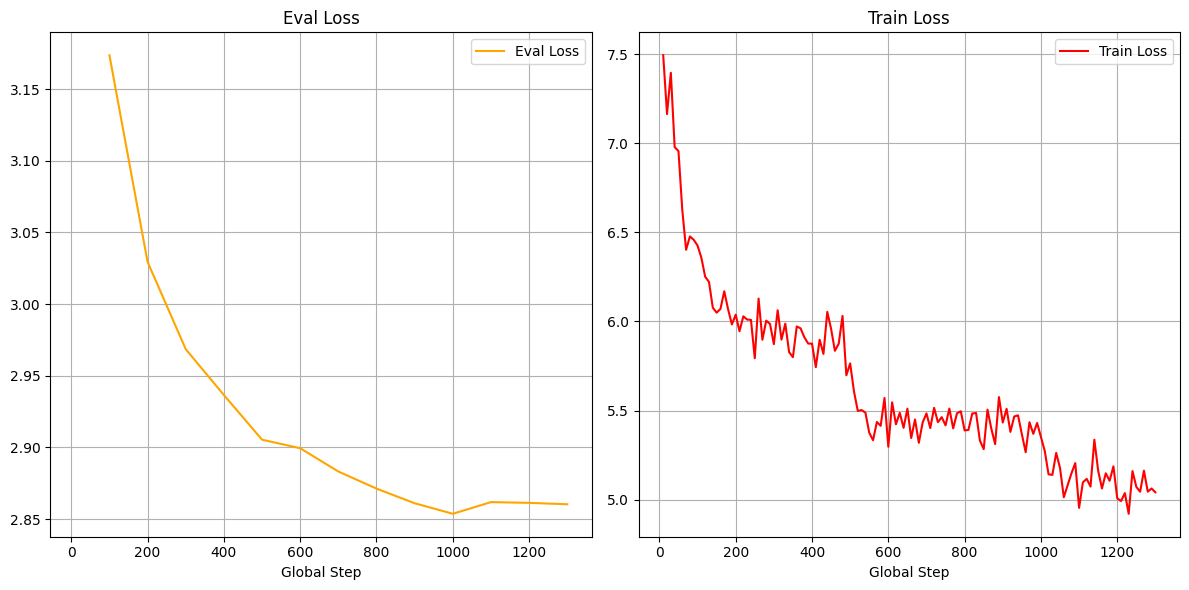

In [ ]:
plot_sft_results('i1hgcxfb')

**Evaluation**

In [ ]:
res_ft_130_piqa_sft = eval_model(model_130, tokenizer, ['piqa'])
print('Fine tuned: ',res_ft_130_piqa_sft['results'])

Mamba 130m (torch.float32) fine-tuned with SFT:

```
{'piqa': {'alias': 'piqa', 'acc,none': 0.6806311207834603, 'acc_stderr,none': 0.010877964076613867, 'acc_norm,none': 0.6605005440696409, 'acc_norm_stderr,none': 0.011048455047173906}}
```

##### float16 and bfloat16
Here we try using float16 and bfloat16 from the models (i.e., we set `torch_dtype=torch.(b)float16`).

**float16**

In [ ]:
dir_130_sft_f16 = "/content/drive/MyDrive/mamba2/piqa/130-sft/mamba-130m-piqa-sft-f16"

params_130m_piqa_sft_f16 = PersonalizedParams(
    output_dir=dir_130_sft_f16,
    num_train_epochs=3,
    eval_steps=100,
    save_steps=1,
    batch_size=16,
    gradient_accumulation_steps=2,
    warmup_ratio=0.1,
    learning_rate=5e-5,
    weight_decay=0.01,
    lr_scheduler_type='cosine'
)

params_130m_piqa_sft_f16

In [ ]:
trainer_130m_sft_f16 = PersonalizedTrainer(
    model = model_130,
    strategy='sft',
    params=params_130m_piqa_sft_f16,
    early_stopping_patience = 3
)

trainer_130m_sft_f16

In [ ]:
finetuner_130_sft_f16 = MambaFineTuner(dataset_piqa, trainer_130m_sft_f16)
finetuner_130_sft_f16.tune(dir_130_sft_f16)

Run id: nfs5nkqk

Run duration: 0:04:16
|   Epoch |   Step |   Train Loss |   Eval Loss |
|--------:|-------:|-------------:|------------:|
|  0.1984 |    100 |            0 |         nan |

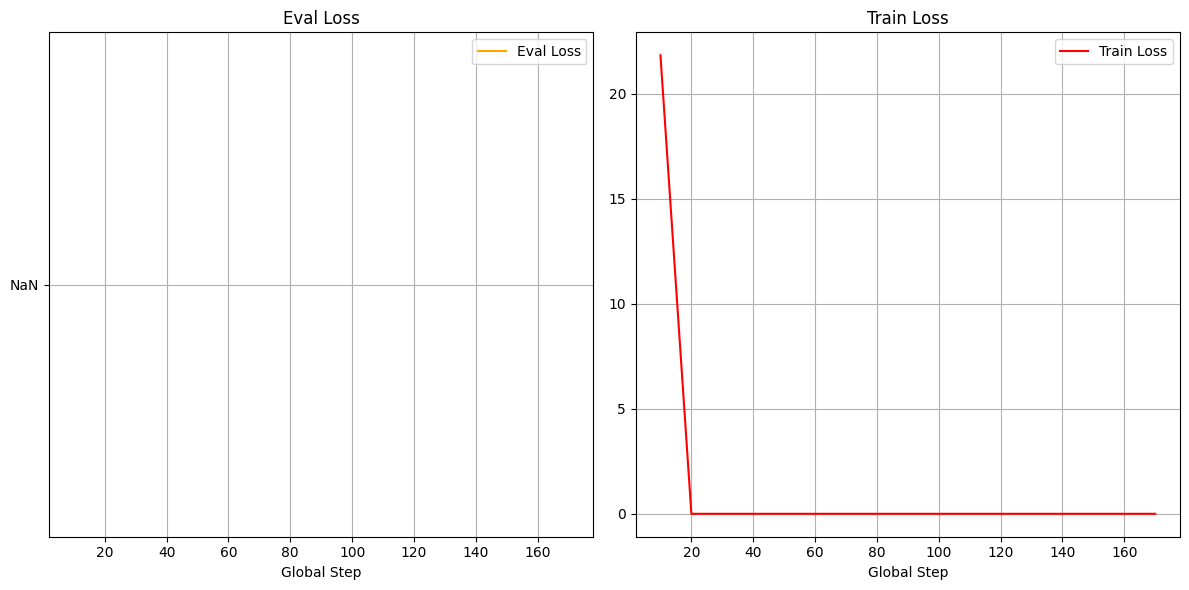

In [ ]:
plot_sft_results('nfs5nkqk')

**Validation**

In [ ]:
res_ft_130_sft_f16 = eval_model(model_130, tokenizer, ['piqa'])
print(f'Fine tuned ({model_130.dtype}): {res_ft_130_sft_f16["results"]}')

Fine tuned (float 16):  
```
{'piqa': {'alias': 'piqa', 'acc,none': 0.49510337323177367, 'acc_stderr,none': 0.01166526473007814, 'acc_norm,none': 0.49510337323177367, 'acc_norm_stderr,none': 0.01166526473007814}}
```

Here we see that the model downgrade, probably it is because some compatibility issues.
Moreover during the training phase logs were pretty weird, e.g. the grandients norm was always NaN and the loss function on the training dataset was always 0.

We did not investigate this results for the reasons said before.

**bfloat16**

In [ ]:
dir_130_sft_bf16 = "/content/drive/MyDrive/mamba2/mamba-piqa-130m-sft-bf16-v2"

params_130m_sft_bf16 = PersonalizedParams(
    output_dir=dir_130_sft_bf16,
    eval_steps=200,
    save_steps=3,
    batch_size=16,
)

params_130m_sft_bf16

In [ ]:
trainer_130m_sft_bf16 = PersonalizedTrainer(
    model = model_130,
    strategy='sft',
    params=params_130m_sft_bf16,
    early_stopping_patience = 3
)

trainer_130m_sft_bf16

In [ ]:
finetuner_130_sft_bf16 = MambaFineTuner(dataset_piqa, trainer_130m_sft_bf16)
finetuner_130_sft_bf16.tune(dir_130_sft_bf16)

Run id: 84gmz55k

Run duration: 0:42:14

|   Epoch |   Step |   Train Loss |   Eval Loss |
|--------:|-------:|-------------:|------------:|
|  0.1984 |    200 |       2.929  |      2.9345 |
|  0.3968 |    400 |       2.7171 |      2.8274 |
|  0.5952 |    600 |       2.6279 |      2.7694 |
|  0.7937 |    800 |       2.7386 |      2.7333 |
|  0.9921 |   1000 |       2.737  |      2.697  |
|  1.1905 |   1200 |       2.396  |      2.6854 |
|  1.3889 |   1400 |       2.5944 |      2.664  |
|  1.5873 |   1600 |       2.5079 |      2.6528 |
|  1.7857 |   1800 |       2.5203 |      2.6412 |
|  1.9841 |   2000 |       2.5874 |      2.631  |
|  2.1825 |   2200 |       2.3553 |      2.6369 |
|  2.381  |   2400 |       2.3096 |      2.6324 |
|  2.5794 |   2600 |       2.3696 |      2.6308 |
|  2.7778 |   2800 |       2.2662 |      2.6279 |
|  2.9762 |   3000 |       2.4901 |      2.6273 |

Run id: 84gmz55k


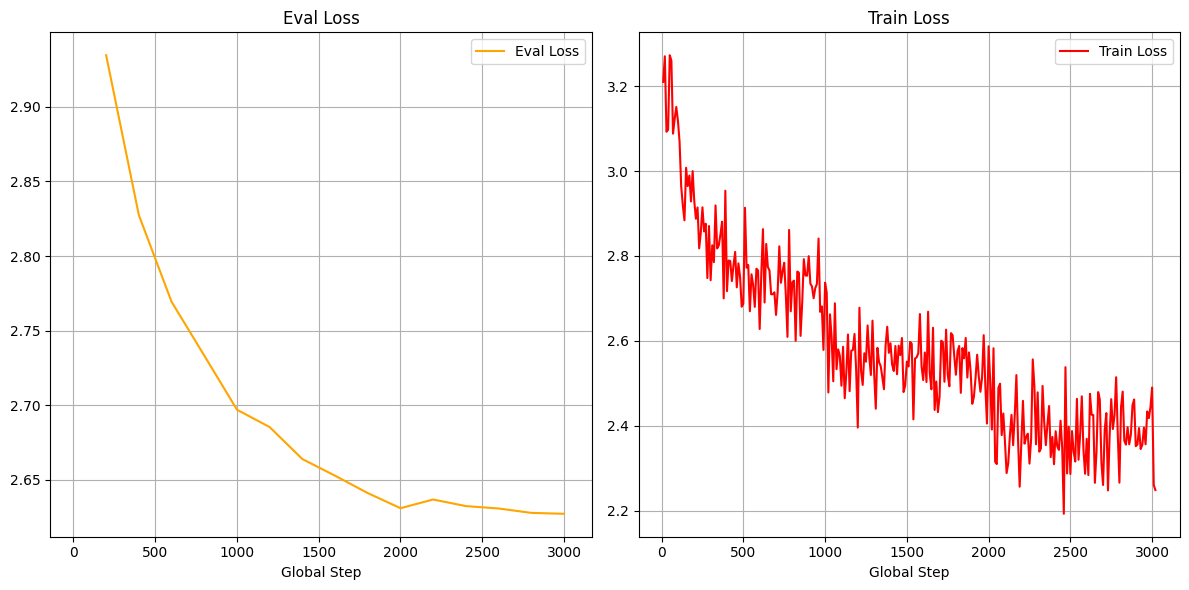

In [ ]:
plot_sft_results('84gmz55k')

**Evaluation**

In [ ]:
res_ft_130_sft_bf16 = eval_model(model_130, tokenizer, ['piqa'])
print('Fine tuned (bfloat 16): ',res_ft_130_sft_bf16['results'])

Fine tuned (bfloat 16):  

```
{'piqa': {'alias': 'piqa', 'acc,none': 0.6735582154515778, 'acc_stderr,none': 0.010940467046177304, 'acc_norm,none': 0.6632208922742111, 'acc_norm_stderr,none': 0.011026738925251179}}
```

Here the results are comparable and the training does not behave weird, but with the model in `torch.float32` the results are better and we can use the mixed precision to make the training faster.

#### DPO

##### float32

In [ ]:
dir_130_dpo = "/content/drive/MyDrive/mamba2/piqa/130-dpo/mamba-130m-piqa-dpo-v8"

params_130m_dpo = PersonalizedParams(
    output_dir=dir_130_dpo,
    num_train_epochs=2,
    eval_steps=100,
    save_steps=3,
    batch_size=4,
    gradient_accumulation_steps=4,
    warmup_ratio=0.0,
    learning_rate=2e-5,
    weight_decay=0.01,
    lr_scheduler_type='cosine'
)

params_130m_dpo.set_param('fp16', True)

params_130m_dpo

In [ ]:
trainer_130m_dpo = PersonalizedTrainer(
    model = model_130,
    strategy='dpo',
    params=params_130m_dpo,
    early_stopping_patience = 3
)

trainer_130m_dpo

In [ ]:
finetuner_130_dpo = MambaFineTuner(dataset_piqa, trainer_130m_dpo)
finetuner_130_dpo.tune(dir_130_dpo)

Run id: i2dds9yk

Run duration: 0:30:47
|   Epoch |   Step |   Train Loss |   Eval Loss |   Eval Accuracy |
|--------:|-------:|-------------:|------------:|----------------:|
|  0.0993 |    100 |       0.6622 |      0.6479 |          0.6543 |
|  0.1986 |    200 |       0.6317 |      0.6363 |          0.669  |
|  0.2978 |    300 |       0.6554 |      0.6297 |          0.6652 |
|  0.3971 |    400 |       0.66   |      0.6178 |          0.6772 |
|  0.4964 |    500 |       0.6146 |      0.6144 |          0.6897 |
|  0.5957 |    600 |       0.5857 |      0.6094 |          0.7022 |
|  0.695  |    700 |       0.5912 |      0.6056 |          0.7043 |
|  0.7942 |    800 |       0.5645 |      0.6029 |          0.7054 |
|  0.8935 |    900 |       0.6012 |      0.6027 |          0.7174 |
|  0.9928 |   1000 |       0.5631 |      0.5987 |          0.7136 |
|  1.0913 |   1100 |       0.2956 |      0.6215 |          0.6995 |
|  1.1906 |   1200 |       0.2857 |      0.6377 |          0.6946 |
|  1.2899 |   1300 |       0.3022 |      0.6449 |          0.6935 |
|  1.3892 |   1400 |       0.2963 |      0.644  |          0.6957 |

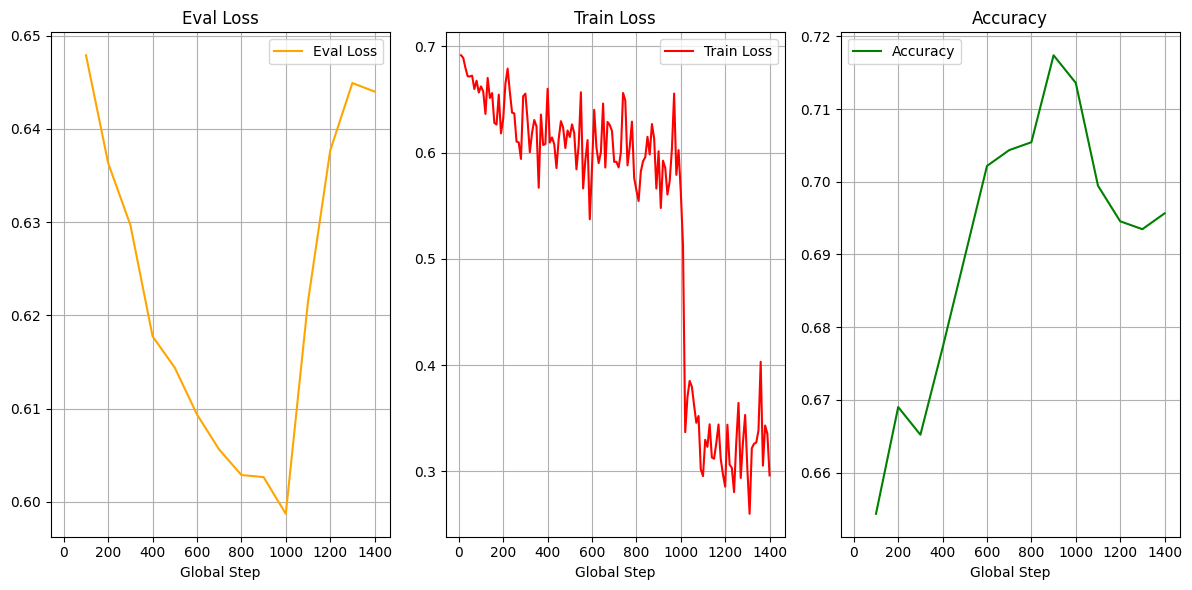

In [ ]:
plot_dpo_results('i2dds9yk')

**Evaluation**

In [ ]:
res_ft_130_dpo = eval_model(model_130, tokenizer, ['piqa'])
print('Fine tuned: ',res_ft_130_dpo['results'])

Mamba 130m (torch.float32) fine-tuned with DPO:
```
{'piqa': {'alias': 'piqa', 'acc,none': 0.6844396082698585, 'acc_stderr,none': 0.010843119201758775, 'acc_norm,none': 0.6855277475516867, 'acc_norm_stderr,none': 0.010833009065106529}}
```

##### bfloat16

Here we did not even try to use the model in `torch.float16` for the reasons said above.

We tried just the model in `torch.bfloat16` to confirm our main idea.

**bfloat16**

In [ ]:
dir_130_dpo_bf16 = "/content/drive/MyDrive/mamba2/mamba-piqa-130m-dpo-bf16-v2"

params_130m_dpo_bf16 = PersonalizedParams(
    output_dir=dir_130_dpo_bf16,
    eval_steps=1000,
    save_steps=3,
    batch_size=4,
)
params_130m_dpo_bf16.set_param('bf16', True)

params_130m_dpo_bf16

PersonalizedParams(
  bf16=True,
  eval_steps=1000,
  eval_strategy='steps',
  gradient_accumulation_steps=1,
  load_best_model_at_end=True,
  metric_for_best_model='eval_loss',
  num_train_epochs=3,
  output_dir='/content/drive/MyDrive/mamba2/mamba-piqa-130m-dpo-bf16-v2',
  per_device_eval_batch_size=4,
  per_device_train_batch_size=4,
  report_to='wandb',
  save_steps=3000,
  save_strategy='steps',
  save_total_limit=1,
  learning_rate=2e-05,
  weight_decay=0.01
  warmup_ratio=0.05
)

In [ ]:
trainer_130m_dpo_bf16 = PersonalizedTrainer(
    model = model_130,
    strategy='dpo',
    params=params_130m_dpo_bf16,
    early_stopping_patience = 3
)

trainer_130m_dpo_bf16

PersonalizedTrainer(
  model=state-spaces/mamba-130m-hf,
  strategy='dpo',
  early_stopping_patience=3
)

In [ ]:
finetuner_130_dpo_bf16 = MambaFineTuner(dataset_piqa, trainer_130m_dpo_bf16)
finetuner_130_dpo_bf16.tune(dir_130_dpo_bf16)

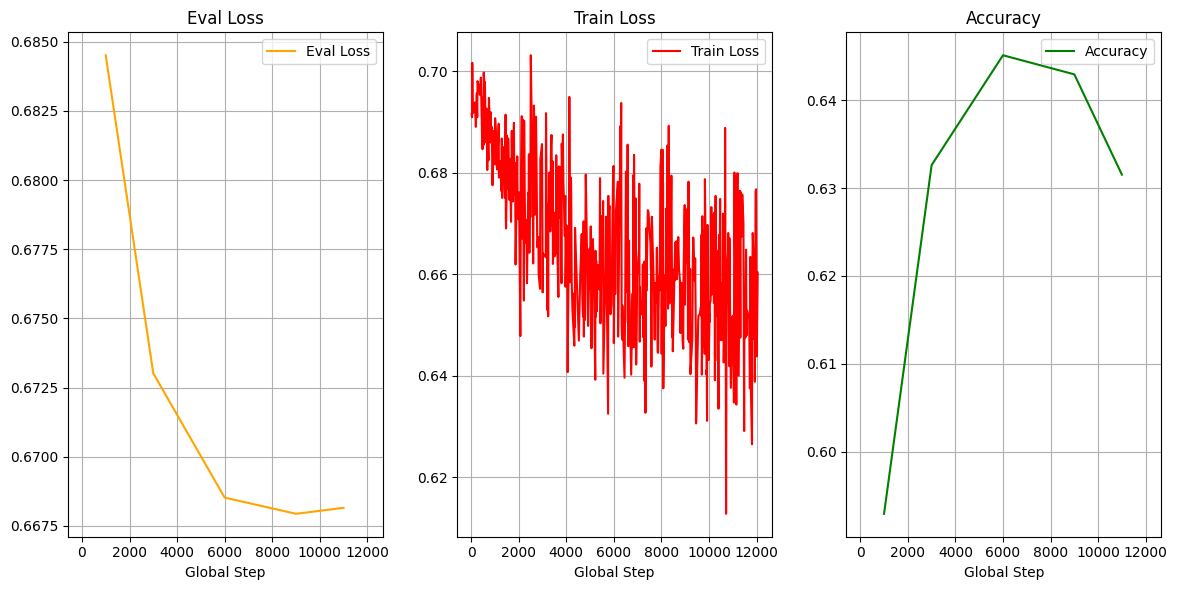

In [ ]:
id_130_dpo_bf16 = '8j7863qg'
plot_dpo_results(id_130_dpo_bf16)

**Evaluation**

In [ ]:
res_ft_130_sft_bf16 = eval_model(model_130, tokenizer, ['piqa'])
print('Fine tuned (bfloat 16): ',res_ft_130_sft_bf16['results'])

Fine tuned (bfloat 16):  
```
{'piqa': {'alias': 'piqa', 'acc,none': 0.6735582154515778, 'acc_stderr,none': 0.010940467046177304, 'acc_norm,none': 0.6632208922742111, 'acc_norm_stderr,none': 0.011026738925251179}}
```

Same considerations as above.

### Mamba 370m

In [ ]:
res_370_piqa = eval_model(model_370, tokenizer, ['piqa'])
print(f'Results base model ({model_370.dtype}): {res_370_piqa["results"]}')

Results base model (torch.float32):

```
{'piqa': {'alias': 'piqa', 'acc,none': 0.6947769314472253, 'acc_stderr,none': 0.010744267045606553, 'acc_norm,none': 0.6833514689880305, 'acc_norm_stderr,none': 0.01085316053197854}}
```

As expected, they are the same as in the original paper.

#### SFT

In [ ]:
dir_370_sft = "/content/drive/MyDrive/mamba2/mamba-piqa-370m-sft-v3"

params_370m_sft = PersonalizedParams(
    output_dir=dir_370_sft,
    eval_steps=100,
    save_steps=1,
    batch_size=4,
    gradient_accumulation_steps=8,
    learning_rate=4e-5,
    weight_decay=0.05,
    warmup_ratio=0.15,
    lr_scheduler_type='cosine'
)

params_370m_sft.set_param('fp16', True)

params_370m_sft

In [ ]:
trainer_370m_sft = PersonalizedTrainer(
    model = model_370,
    strategy='sft',
    params=params_370m_sft,
    early_stopping_patience = 5
)

trainer_370m_sft

In [ ]:
finetuner_370_sft = MambaFineTuner(dataset_piqa, trainer_370m_sft)
finetuner_370_sft.tune(dir_370_sft)

Run id: gpuc6b0u

Run duration: 0:56:11
|   Epoch |   Step |   Train Loss |   Eval Loss |
|--------:|-------:|-------------:|------------:|
|  0.1986 |    100 |      23.5649 |      2.8635 |
|  0.3971 |    200 |      22.3542 |      2.7476 |
|  0.5957 |    300 |      21.9925 |      2.7041 |
|  0.7942 |    400 |      21.5133 |      2.6745 |
|  0.9928 |    500 |      21.067  |      2.6435 |
|  1.1906 |    600 |      18.0363 |      2.671  |
|  1.3892 |    700 |      18.6284 |      2.6546 |
|  1.5877 |    800 |      18.4373 |      2.6386 |
|  1.7863 |    900 |      18.5366 |      2.627  |
|  1.9849 |   1000 |      18.0429 |      2.6172 |
|  2.1827 |   1100 |      14.6181 |      2.7198 |
|  2.3812 |   1200 |      14.8336 |      2.7205 |
|  2.5798 |   1300 |      14.9064 |      2.7167 |
|  2.7784 |   1400 |      14.9578 |      2.7194 |
|  2.9769 |   1500 |      15.3961 |      2.7186 |

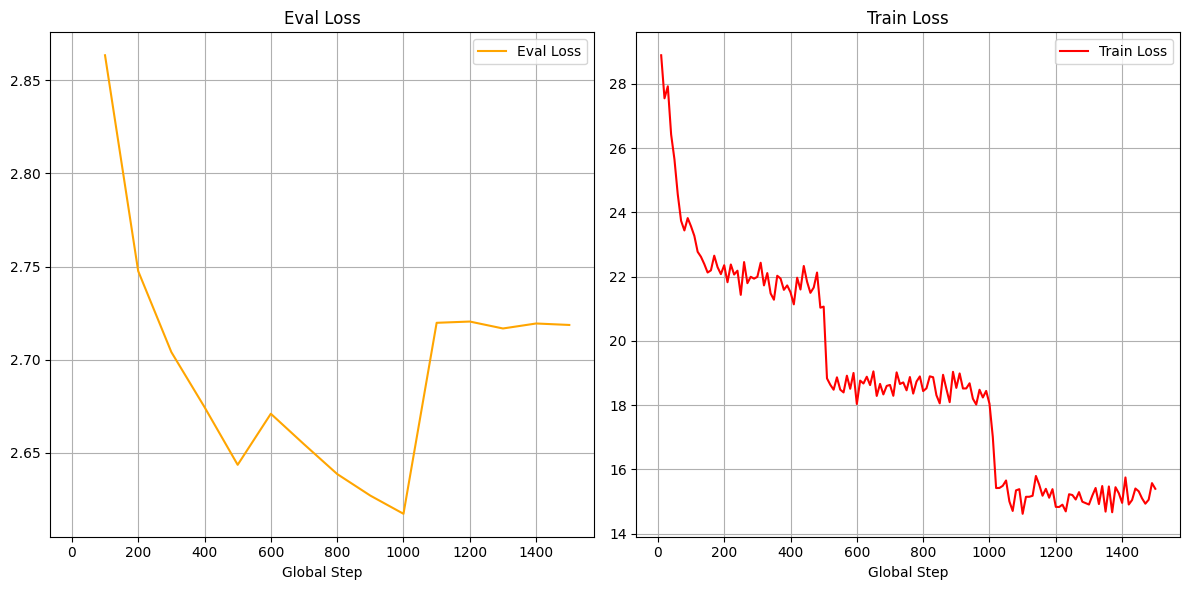

In [ ]:
plot_sft_results('gpuc6b0u')

**Evaluation**

In [ ]:
res_ft_370_sft = eval_model(model_370, tokenizer, ['piqa'])
print('Fine tuned: ',res_ft_370_sft['results'])

Mamba 370m (torch.float32) fine-tuned with SFT:
```
{'piqa': {'alias': 'piqa', 'acc,none': 0.7312295973884657, 'acc_stderr,none': 0.01034339294008991, 'acc_norm,none': 0.7383025027203483, 'acc_norm_stderr,none': 0.010255630772708123}}
```

#### DPO

In [ ]:
dir_370_dpo = "/content/drive/MyDrive/mamba2/piqa/370-dpo/mamba-370m-piqa-dpo-v4"

params_370m_dpo = PersonalizedParams(
    output_dir=dir_370_dpo,
    eval_steps=100,
    save_steps=1,
    batch_size=2,
    gradient_accumulation_steps=8,
    metric_for_best_model='rewards/accuracies',
    learning_rate=2e-5,
    weight_decay=0.01,
    warmup_ratio=0.0,
    lr_scheduler_type='cosine',
    num_train_epochs=2
)

params_370m_dpo.set_param('fp16', True)
params_370m_dpo.set_param('greater_is_better', True)

params_370m_dpo

In [ ]:
trainer_370m_dpo = PersonalizedTrainer(
    model = model_370,
    strategy='dpo',
    params=params_370m_dpo,
    early_stopping_patience = 3
)

trainer_370m_dpo

In [ ]:
finetuner_370_dpo = MambaFineTuner(dataset_piqa, trainer_370m_dpo)
finetuner_370_dpo.tune(save=dir_370_dpo)

Run id: cc35khm9

Run duration: 1:21:13
|   Epoch |   Step |   Train Loss |   Eval Loss |   Eval Accuracy |
|--------:|-------:|-------------:|------------:|----------------:|
|  0.0993 |    100 |       0.6644 |      0.6064 |          0.71   |
|  0.1986 |    200 |       0.6027 |      0.5924 |          0.7106 |
|  0.2979 |    300 |       0.5913 |      0.5696 |          0.7378 |
|  0.3972 |    400 |       0.5757 |      0.5615 |          0.7383 |
|  0.4965 |    500 |       0.571  |      0.5444 |          0.7557 |
|  0.5958 |    600 |       0.5069 |      0.5313 |          0.7633 |
|  0.695  |    700 |       0.5462 |      0.5304 |          0.7606 |
|  0.7943 |    800 |       0.4215 |      0.5187 |          0.7639 |
|  0.8936 |    900 |       0.5019 |      0.5235 |          0.7682 |
|  0.9929 |   1000 |       0.4519 |      0.5104 |          0.7699 |
|  1.0913 |   1100 |       0.1017 |      0.5984 |          0.7601 |
|  1.1906 |   1200 |       0.0991 |      0.6231 |          0.7606 |
|  1.2899 |   1300 |       0.1578 |      0.6271 |          0.7622 |

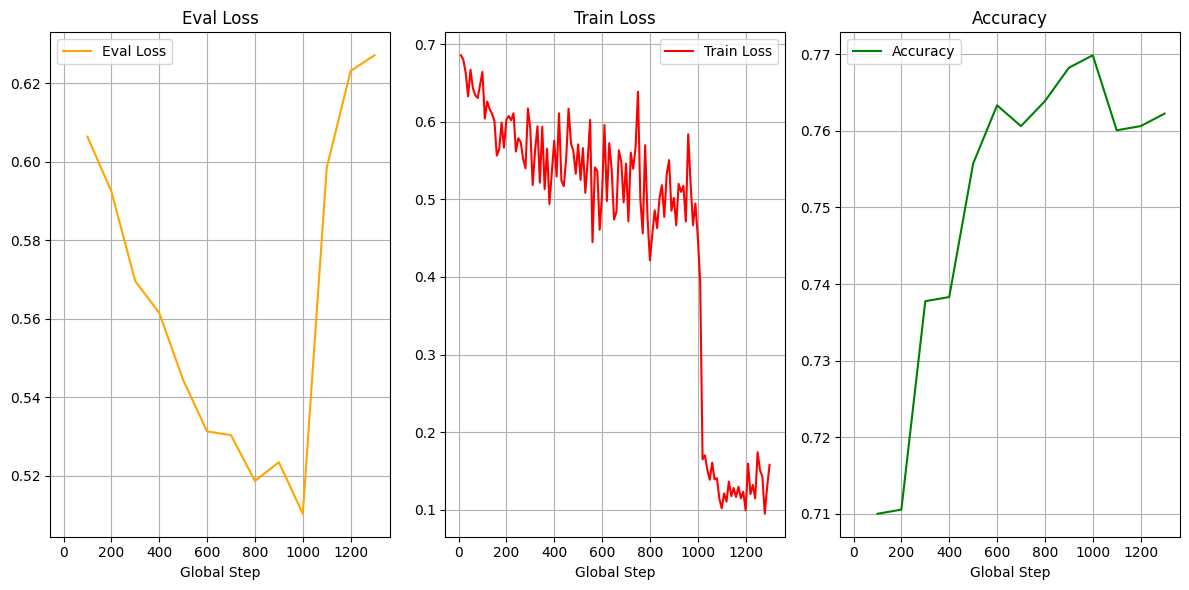

In [ ]:
plot_dpo_results('cc35khm9')

**Evaluation**

In [ ]:
res_ft_370_dpo = eval_model(model_370, tokenizer, ['piqa'])
print('Fine tuned: ',res_ft_370_dpo['results'])

Mamba 370m (torch.float32) fine-tuned with DPO:
```
{'piqa': {'alias': 'piqa', 'acc,none': 0.7616974972796517, 'acc_stderr,none': 0.009940334245876358, 'acc_norm,none': 0.763873775843308, 'acc_norm_stderr,none': 0.009908965890558312}}
```

### Mamba 790m


In [ ]:
res_790_piqa = eval_model(model_790, tokenizer, ['piqa'])
print(f'Results base model ({model_790.dtype}): {res_790_piqa["results"]}')

Results base model (torch.float32):
```
{'piqa': {'alias': 'piqa', 'acc,none': 0.721436343852013, 'acc_stderr,none': 0.01045939723596504, 'acc_norm,none': 0.7263329706202394, 'acc_norm_stderr,none': 0.010402184206229258}}
```

Same as the paper.

#### SFT


In [ ]:
dir_790_sft = "/content/drive/MyDrive/mamba2/790-sft/mamba-790m-piqa-sft"

params_790m_sft = PersonalizedParams(
    output_dir=dir_790_sft,
    eval_steps=200,
    save_steps=1,
    batch_size=1,
    gradient_accumulation_steps=16,
    learning_rate=4e-5,
    weight_decay=0.01,
    warmup_ratio=0.1,
    lr_scheduler_type='cosine'
)

params_790m_sft.set_param('bf16', True)

params_790m_sft

In [ ]:
trainer_790m_sft = PersonalizedTrainer(
    model = model_790,
    strategy='sft',
    params=params_790m_sft,
    early_stopping_patience = 3
)

trainer_790m_sft

In [ ]:
finetuner_790_sft = MambaFineTuner(dataset_piqa, trainer_790m_sft)
finetuner_790_sft.tune(save=dir_790_sft)

Run id: 4pe5wll1

Run duration: 3:47:43.283868
|   Epoch |   Step |   Train Loss |   Eval Loss |
|--------:|-------:|-------------:|------------:|
|  0.1986 |    200 |      54.049  |      3.3611 |
|  0.3972 |    400 |      47.5302 |      3.0006 |
|  0.5958 |    600 |      46.6247 |      2.8909 |
|  0.7944 |    800 |      46.6755 |      2.8422 |
|  0.993  |   1000 |      44.5762 |      2.813  |
|  1.1907 |   1200 |      42.1933 |      2.7973 |
|  1.3893 |   1400 |      43.1159 |      2.7856 |
|  1.5878 |   1600 |      41.9213 |      2.7768 |
|  1.7864 |   1800 |      43.2266 |      2.7738 |
|  1.985  |   2000 |      43.8596 |      2.7702 |
|  2.1827 |   2200 |      41.8203 |      2.7685 |

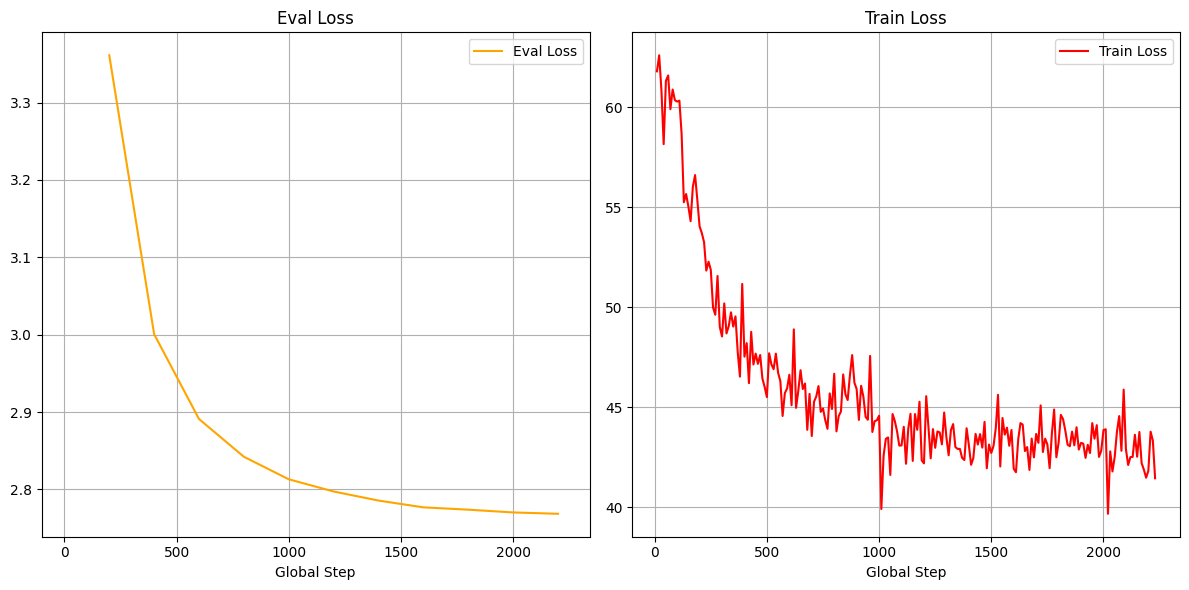

In [ ]:
plot_sft_results('4pe5wll1')

**Evaluation**

In [ ]:
res_ft_790_sft = eval_model(model_790, tokenizer, ['piqa'])
print('Fine tuned: ',res_ft_790_sft['results'])

Mamba 790m (`torch.float32`) fine-tuned with SFT:
```
Fine tuned:  {'piqa': {'alias': 'piqa', 'acc,none': 0.733949945593036, 'acc_stderr,none': 0.010310039263352765, 'acc_norm,none': 0.7377584330794341, 'acc_norm_stderr,none': 0.010262502565172393}}
```

#### DPO


In [ ]:
dir_790_dpo = "/content/drive/MyDrive/mamba2/piqa/790-dpo/mamba-790m-piqa-dpo"

params_790m_dpo = PersonalizedParams(
    output_dir=dir_790_dpo,
    eval_steps=200,
    save_steps=5,
    batch_size=2,
    gradient_accumulation_steps=8,
    metric_for_best_model='rewards/accuracies',
    learning_rate=4e-5,
    weight_decay=0.01,
    warmup_ratio=0.1,
    lr_scheduler_type='cosine',
    num_train_epochs=2
)

params_790m_dpo.set_param('bf16', True)
params_790m_dpo.set_param('bf16_full_eval', True)
params_790m_dpo.set_param('greater_is_better', True)

params_790m_dpo

In [ ]:
trainer_790m_dpo = PersonalizedTrainer(
    model = model_790,
    strategy='dpo',
    params=params_790m_dpo,
    early_stopping_patience = 3
)

trainer_790m_dpo

In [ ]:
finetuner_790_dpo = MambaFineTuner(dataset_piqa, trainer_790m_dpo)
finetuner_790_dpo.tune(save=dir_790_dpo)

Run id: npp92zb6

Run duration: 3:41:43
|   Epoch |   Step |   Train Loss |   Eval Loss |   Eval Accuracy |
|--------:|-------:|-------------:|------------:|----------------:|
|  0.1986 |    200 |       0.6679 |      0.6607 |          0.6703 |
|  0.3972 |    400 |       0.6452 |      0.5978 |          0.7155 |
|  0.5958 |    600 |       0.5669 |      0.569  |          0.7383 |
|  0.7943 |    800 |       0.5441 |      0.5479 |          0.7492 |
|  0.9929 |   1000 |       0.5579 |      0.5373 |          0.7612 |
|  1.1906 |   1200 |       0.3501 |      0.5324 |          0.759  |
|  1.3892 |   1400 |       0.4017 |      0.533  |          0.7573 |

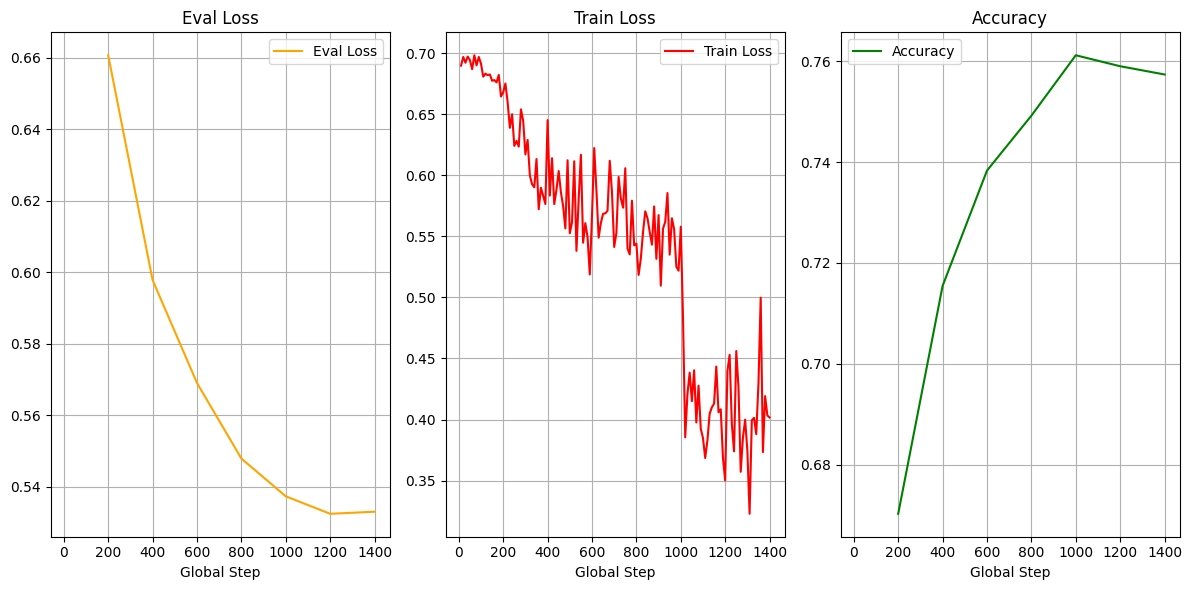

In [ ]:
plot_dpo_results('npp92zb6')

**Evaluation**

In [ ]:
model_790 = AutoModelForCausalLM.from_pretrained(dir_790_dpo+'/checkpoint-1000')
model_790.to(device)

MambaForCausalLM(
  (backbone): MambaModel(
    (embeddings): Embedding(50280, 1536)
    (layers): ModuleList(
      (0-47): 48 x MambaBlock(
        (norm): MambaRMSNorm(1536, eps=1e-05)
        (mixer): MambaMixer(
          (conv1d): Conv1d(3072, 3072, kernel_size=(4,), stride=(1,), padding=(3,), groups=3072)
          (act): SiLU()
          (in_proj): Linear(in_features=1536, out_features=6144, bias=False)
          (x_proj): Linear(in_features=3072, out_features=128, bias=False)
          (dt_proj): Linear(in_features=96, out_features=3072, bias=True)
          (out_proj): Linear(in_features=3072, out_features=1536, bias=False)
        )
      )
    )
    (norm_f): MambaRMSNorm(1536, eps=1e-05)
  )
  (lm_head): Linear(in_features=1536, out_features=50280, bias=False)
)

In [ ]:
res_ft_790_dpo = eval_model(model_790, tokenizer, ['piqa'])
print('Fine tuned: ',res_ft_790_dpo['results'])

Mamba 790m (`torch.bfloat16`) fine-tuned with DPO:

```
Fine tuned:  {'piqa': {'alias': 'piqa', 'acc,none': 0.7535364526659413, 'acc_stderr,none': 0.01005481078967165, 'acc_norm,none': 0.750816104461371, 'acc_norm_stderr,none': 0.010091882770120146}}
```

## PIQA - LoRA

We tried Low-Rank Adaptation (LoRA), to see if this technique could improve the results we already got.

LoRA is an improved finetuning method where instead of finetuning all the weights that constitute the weight matrix of the pre-trained large language model, two smaller matrices that approximate this larger matrix are fine-tuned.

Let's dive into it.

The major downside of fine-tuning is that the new model contains as many parameters as in the original model.
This represents an efficiency problem, because all of the weights need to be trained.

To improve the efficiency of fine-tuning large models,  LoRA introduces a parameter-efficient approach based on low-rank decomposition. Instead of updating all model parameters, LoRA represents weight updates using two smaller trainable matrices, commonly referred to as *update matrices*. These matrices are optimized to adapt the model to new data, while the original pre-trained weights remain frozen.

At inference, the adapted weights are combined with the frozen base weights to produce the final outputs.

This design brings several key advantages:

* Parameter efficiency: LoRA significantly reduces the number of trainable parameters, enabling faster training with lower memory requirements.
* Modularity: Since the pre-trained weights remain unchanged, multiple lightweight LoRA adapters can be trained for different downstream tasks on the same base model, making them portable and reusable.
* Compatibility: LoRA is orthogonal to many other parameter-efficient fine-tuning methods and can be easily combined with them.
* Performance: Models fine-tuned with LoRA achieve performance comparable to fully fine-tuned models, despite the reduced training overhead.
* No added inference latency: Because the adapter weights can be merged with the base model, inference speed remains unaffected.

In practice, LoRA can be applied to any subset of weight matrices within a neural network.
The number of trainable parameters depends on the rank $r$ of the low-rank update matrices relative to the dimensions of the original weight matrix.

While LoRA adapters are small and efficient, maintaining them separately can introduce latency during inference, since both the base model and LoRA weights must be loaded.
A solution is represented by merging the model and the new set of weights.


<figure>
<img src='https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/peft/lora_diagram.png'>
<figcaption>Image from 14.</figcaption>
</figure>
<!-- ![Image from 14.](lora.png)
_Image from 14._ -->

After merging, the model can be used as a standalone version, eliminating additional inference overhead. This is possible because the two low-rank matrices (commonly denoted as $A$ and $B$) can be recombined into a single matrix that is mathematically equivalent to the fully updated weight matrix.




**LoRA configuration**

To investigate the efficiency of parameter-efficient fine-tuning, we conducted a series of experiments applying Low-Rank Adaptation (LoRA) to different Mamba model scales: 130M, 370M, 790M, and 1.4B parameters. Each model was fine-tuned on the PIQA dataset using both SFT and DPO.

For consistency across experiments, we used a fixed LoRA configuration defined through the Hugging Face `peft` library. The configuration parameters were:

* `rank_dimension = 16`
  
  This parameter controls the size of the low-rank decomposition used to approximate weight updates. A smaller rank reduces the number of trainable parameters, making fine-tuning more efficient, but may limit expressive capacity.

* `lora_alpha = 32`

  This scaling factor adjusts the impact of the LoRA updates relative to the frozen base weights. It effectively re-scales the low-rank updates before they are added back to the original weights, helping stabilize training and ensuring that the updates are neither too weak nor excessively dominant.

* `lora_dropout = 0.1` (10%)

  Dropout probability applied to the LoRA updates during training. It helps regularize the adaptation process and reduce overfitting.

* `target_modules=["x_proj", "dt_proj", "in_proj", "embeddings"]`

  These modules are the suggested from the Hugging Face documentation for Mamba models, except for `out_proj`, that is not supported by LoRA anymore.

* `task_type="CAUSAL_LM"`

This configuration (referred to as `peft_config`) was chosen to provide a balanced tradeoff between efficiency and performance, while enabling systematic comparison across different model sizes and training strategies.


In [ ]:
from peft import LoraConfig

rank_dimension = 16
lora_alpha = 32
lora_dropout = 0.1

peft_config = LoraConfig(
    r=rank_dimension,
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    bias="none",
    target_modules=["x_proj", "dt_proj", "in_proj", "embeddings"],
    task_type="CAUSAL_LM",
)

### 130m

#### SFT

In [ ]:
dir_130_piqa_sft = "/content/drive/MyDrive/mamba2/piqa/lora/mamba-130m-piqa-sft-lora-v4"

params_130m_piqa_sft = PersonalizedParams(
    output_dir=dir_130_piqa_sft,
    num_train_epochs=3,
    eval_steps=100,
    save_steps=3,
    batch_size=16,
    gradient_accumulation_steps=2,
    warmup_ratio=0.1,
    learning_rate=4e-5,
    weight_decay=0.005,
)

params_130m_piqa_sft.set_param('fp16', True)

params_130m_piqa_sft

In [ ]:
trainer_130m_piqa_sft = PersonalizedTrainer(
    model = model_130,
    strategy='sft',
    params=params_130m_piqa_sft,
    early_stopping_patience = 5,
    peft_config=peft_config
)

trainer_130m_piqa_sft

In [ ]:
finetuner_130_piqa_sft = MambaFineTuner(dataset_piqa, trainer_130m_piqa_sft)
finetuner_130_piqa_sft.tune(dir_130_piqa_sft)

Run id: ojw9e0gl

Run duration: 0:24:19
|   Epoch |   Step |   Train Loss |   Eval Loss |
|--------:|-------:|-------------:|------------:|
|  0.1984 |    100 |       7.3099 |      3.6427 |
|  0.3968 |    200 |       6.5652 |      3.2877 |
|  0.5952 |    300 |       6.2375 |      3.1893 |
|  0.7937 |    400 |       6.2775 |      3.1449 |
|  0.9921 |    500 |       6.122  |      3.1178 |
|  1.1905 |    600 |       5.9526 |      3.0989 |
|  1.3889 |    700 |       6.0939 |      3.085  |
|  1.5873 |    800 |       6.0016 |      3.0752 |
|  1.7857 |    900 |       6.0719 |      3.0665 |
|  1.9841 |   1000 |       5.9793 |      3.0603 |
|  2.1825 |   1100 |       5.8306 |      3.0555 |
|  2.381  |   1200 |       5.9137 |      3.0523 |
|  2.5794 |   1300 |       5.9013 |      3.0499 |
|  2.7778 |   1400 |       5.965  |      3.0484 |
|  2.9762 |   1500 |       6.1359 |      3.0477 |

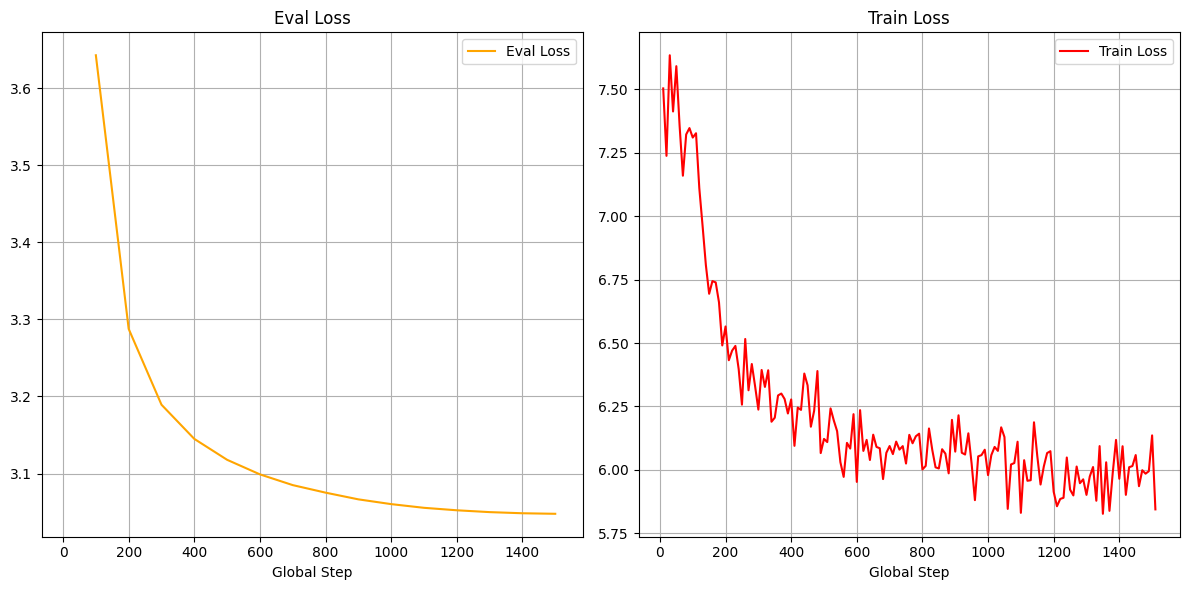

In [ ]:
plot_sft_results('ojw9e0gl')

In [ ]:
res_ft_130_piqa_sft = eval_model(model_130, tokenizer, ['piqa'])
print('Fine tuned: ',res_ft_130_piqa_sft['results'])

Mamba 130m fine-tuned with LoRA and SFT:

```
{'piqa': {'alias': 'piqa', 'acc,none': 0.6507072905331882, 'acc_stderr,none': 0.011123283817525193, 'acc_norm,none': 0.6436343852013058, 'acc_norm_stderr,none': 0.01117410986586477}}
```

#### DPO

In [ ]:
dir_130_piqa_dpo = "/content/drive/MyDrive/mamba2/piqa/lora/mamba-130m-piqa-dpo-lora"

params_130m_piqa_dpo = PersonalizedParams(
    output_dir=dir_130_piqa_dpo,
    num_train_epochs=2,
    eval_steps=100,
    save_steps=3,
    batch_size=4,
    gradient_accumulation_steps=4,
    warmup_ratio=0.0,
    learning_rate=2e-5,
    weight_decay=0.01,
    lr_scheduler_type='cosine'
)

params_130m_piqa_dpo.set_param('fp16', True)

params_130m_piqa_dpo

In [ ]:
trainer_130m_piqa_dpo = PersonalizedTrainer(
    model = model_130,
    strategy='dpo',
    params=params_130m_piqa_dpo,
    early_stopping_patience = 5,
    peft_config=peft_config
)

trainer_130m_piqa_dpo

In [ ]:
finetuner_130_piqa_dpo = MambaFineTuner(dataset_piqa, trainer_130m_piqa_dpo)
finetuner_130_piqa_dpo.tune(dir_130_piqa_dpo)

Run id: 0zyrmcvm

Run duration: 0:47:51
|   Epoch |   Step |   Train Loss |   Eval Loss |   Eval Accuracy |
|--------:|-------:|-------------:|------------:|----------------:|
|  0.0993 |    100 |       0.6915 |      0.691  |          0.6228 |
|  0.1986 |    200 |       0.6861 |      0.6872 |          0.6467 |
|  0.2978 |    300 |       0.6828 |      0.68   |          0.6397 |
|  0.3971 |    400 |       0.6771 |      0.6715 |          0.6457 |
|  0.4964 |    500 |       0.6658 |      0.661  |          0.6511 |
|  0.5957 |    600 |       0.6558 |      0.654  |          0.6489 |
|  0.695  |    700 |       0.6512 |      0.6498 |          0.6462 |
|  0.7942 |    800 |       0.6364 |      0.6474 |          0.6543 |
|  0.8935 |    900 |       0.6413 |      0.6455 |          0.6533 |
|  0.9928 |   1000 |       0.6258 |      0.6444 |          0.6549 |
|  1.0913 |   1100 |       0.5961 |      0.6435 |          0.6538 |
|  1.1906 |   1200 |       0.589  |      0.6431 |          0.6543 |
|  1.2899 |   1300 |       0.5917 |      0.6431 |          0.6527 |
|  1.3892 |   1400 |       0.6082 |      0.6429 |          0.6543 |
|  1.4885 |   1500 |       0.6447 |      0.6426 |          0.6543 |
|  1.5877 |   1600 |       0.6429 |      0.6425 |          0.6554 |
|  1.687  |   1700 |       0.5771 |      0.6424 |          0.6565 |
|  1.7863 |   1800 |       0.6183 |      0.6423 |          0.6554 |
|  1.8856 |   1900 |       0.601  |      0.6425 |          0.6549 |
|  1.9849 |   2000 |       0.629  |      0.6423 |          0.6571 |

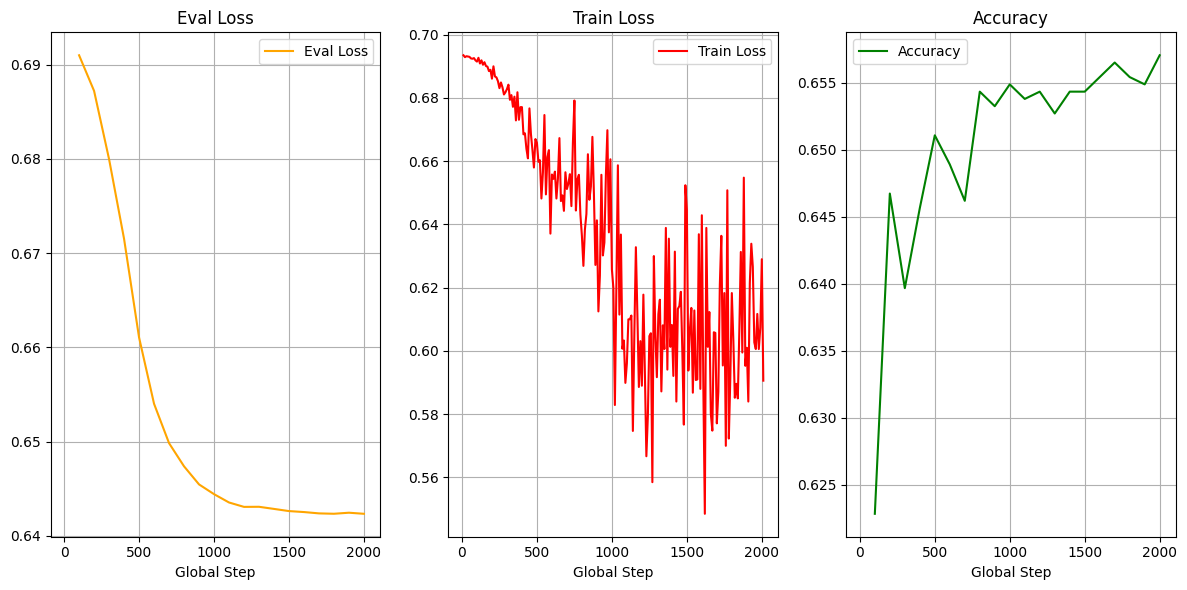

In [ ]:
plot_dpo_results('0zyrmcvm')

In [ ]:
res_ft_130_piqa_sft = eval_model(model_130, tokenizer, ['piqa'])
print('Fine tuned: ',res_ft_130_piqa_sft['results'])

Mamba 130m fine-tuned with LoRA and DPO:

```
{'piqa': {'alias': 'piqa', 'acc,none': 0.6556039173014145, 'acc_stderr,none': 0.011086521237125654, 'acc_norm,none': 0.6637649619151251, 'acc_norm_stderr,none': 0.01102234670897027}}
```

### 370m

#### SFT

In [ ]:
dir_370_sft = "/content/drive/MyDrive/mamba2/piqa/lora/mamba-370m-piqa-sft-lora"

params_370m_sft = PersonalizedParams(
    output_dir=dir_370_sft,
    eval_steps=100,
    save_steps=2,
    batch_size=4,
    gradient_accumulation_steps=8,
    learning_rate=5e-5,
    weight_decay=0.01,
    warmup_ratio=0.1,
    lr_scheduler_type='cosine',
    num_train_epochs=3
)

params_370m_sft.set_param('fp16', True)

params_370m_sft

PersonalizedParams(
  eval_steps=100,
  eval_strategy='steps',
  fp16=True,
  gradient_accumulation_steps=8,
  learning_rate=5e-05,
  load_best_model_at_end=True,
  lr_scheduler_type='cosine',
  metric_for_best_model='eval_loss',
  num_train_epochs=3,
  output_dir='/content/drive/MyDrive/mamba2/piqa/lora/mamba-370m-piqa-sft-lora',
  per_device_eval_batch_size=4,
  per_device_train_batch_size=4,
  report_to='wandb',
  save_safetensors=False,
  save_steps=200,
  save_strategy='steps',
  save_total_limit=1,
  warmup_ratio=0.1,
  weight_decay=0.01,
)

In [ ]:
trainer_370m_sft = PersonalizedTrainer(
    model = model_370,
    strategy='sft',
    params=params_370m_sft,
    early_stopping_patience = 5,
    peft_config=peft_config
)

trainer_370m_sft

In [ ]:
finetuner_370_sft = MambaFineTuner(dataset_piqa, trainer_370m_sft)
finetuner_370_sft.tune(dir_370_sft)

Run id: qfvu6gbc

Run duration: 0:55:41
|   Epoch |   Step |   Train Loss |   Eval Loss |
|--------:|-------:|-------------:|------------:|
|  0.1986 |    100 |      27.7763 |      3.4065 |
|  0.3971 |    200 |      24.1155 |      2.9898 |
|  0.5957 |    300 |      23.1279 |      2.8881 |
|  0.7942 |    400 |      22.7005 |      2.8484 |
|  0.9928 |    500 |      22.1553 |      2.8265 |
|  1.1906 |    600 |      21.7459 |      2.81   |
|  1.3892 |    700 |      22.146  |      2.7971 |
|  1.5877 |    800 |      21.9754 |      2.788  |
|  1.7863 |    900 |      22.1186 |      2.781  |
|  1.9849 |   1000 |      21.7251 |      2.7766 |
|  2.1827 |   1100 |      21.243  |      2.7734 |
|  2.3812 |   1200 |      21.6281 |      2.7711 |
|  2.5798 |   1300 |      21.6626 |      2.7699 |
|  2.7784 |   1400 |      21.7202 |      2.7695 |
|  2.9769 |   1500 |      22.4553 |      2.7694 |

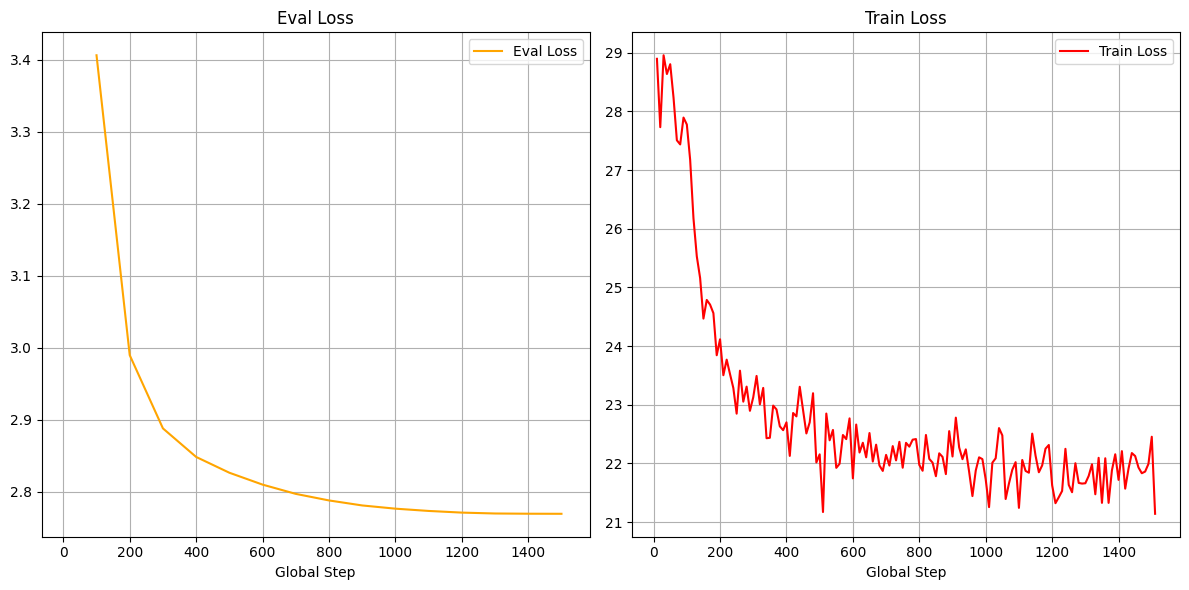

In [ ]:
plot_sft_results('qfvu6gbc')

**Evaluation**

In [ ]:
res_ft_370_sft = eval_model(model_370, tokenizer, ['piqa'])
print('Fine tuned: ',res_ft_370_sft['results'])

Mamba 370m fine-tuned with LoRA and SFT:

```
Fine tuned:  {'piqa': {'alias': 'piqa', 'acc,none': 0.7072905331882481, 'acc_stderr,none': 0.010616044462393127, 'acc_norm,none': 0.7040261153427638, 'acc_norm_stderr,none': 0.01065041431714814}}
```

#### DPO

In [ ]:
dir_370_dpo = "/content/drive/MyDrive/mamba2/piqa/lora/mamba-370m-piqa-dpo-lora-v2"

params_370m_dpo = PersonalizedParams(
    output_dir=dir_370_dpo,
    eval_steps=200,
    save_steps=2,
    batch_size=2,
    gradient_accumulation_steps=8,
    metric_for_best_model='rewards/accuracies',
    learning_rate=2e-5,
    weight_decay=0.01,
    warmup_ratio=0.0,
    lr_scheduler_type='cosine',
    num_train_epochs=2
)

params_370m_dpo.set_param('fp16', True)
params_370m_dpo.set_param('greater_is_better', True)

params_370m_dpo

In [ ]:
trainer_370m_dpo = PersonalizedTrainer(
    model = model_370,
    strategy='dpo',
    params=params_370m_dpo,
    early_stopping_patience = 3,
    peft_config=peft_config
)

trainer_370m_dpo

In [ ]:
finetuner_370_dpo = MambaFineTuner(dataset_piqa, trainer_370m_dpo)
finetuner_370_dpo.tune(dir_370_dpo)

Run id: poi0skn6

Run duration: 1:42:39
|   Epoch |   Step |   Train Loss |   Eval Loss |   Eval Accuracy |
|--------:|-------:|-------------:|------------:|----------------:|
|  0.1986 |    200 |       0.6805 |      0.6795 |          0.6746 |
|  0.3972 |    400 |       0.6421 |      0.6437 |          0.6872 |
|  0.5958 |    600 |       0.617  |      0.6193 |          0.698  |
|  0.7943 |    800 |       0.599  |      0.6103 |          0.698  |
|  0.9929 |   1000 |       0.5862 |      0.605  |          0.7008 |
|  1.1906 |   1200 |       0.5353 |      0.6029 |          0.7024 |
|  1.3892 |   1400 |       0.5341 |      0.6009 |          0.7046 |
|  1.5878 |   1600 |       0.5711 |      0.6003 |          0.7024 |
|  1.7864 |   1800 |       0.5426 |      0.6001 |          0.7024 |
|  1.985  |   2000 |       0.5762 |      0.6    |          0.7018 |

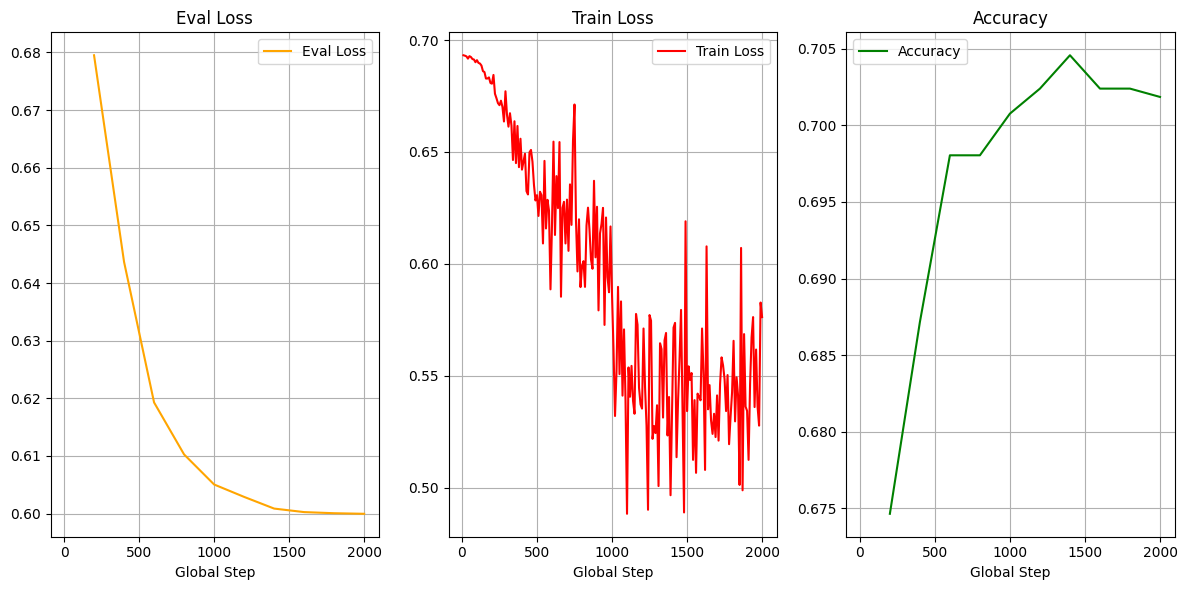

In [ ]:
plot_dpo_results('poi0skn6')

**Evaluation**

In [ ]:
res_ft_370_dpo = eval_model(model_370, tokenizer, ['piqa'])
print('Fine tuned: ',res_ft_370_dpo['results'])

Mamba 370m fine-tuned with DPO and LoRA:
```
{'piqa': {'alias': 'piqa', 'acc,none': 0.70620239390642, 'acc_stderr,none': 0.010627574080514925, 'acc_norm,none': 0.7029379760609358, 'acc_norm_stderr,none': 0.010661725404814675}}
```

### 790m

#### SFT

In [ ]:
dir_790_sft = "/content/drive/MyDrive/mamba2/piqa/lora/mamba-790m-piqa-sft-lora-v3"

params_790m_sft = PersonalizedParams(
    output_dir=dir_790_sft,
    eval_steps=100,
    batch_size=4,
    gradient_accumulation_steps=8,
    learning_rate=5e-5,
    weight_decay=0.01,
    warmup_ratio=0.1,
    lr_scheduler_type='cosine',
    num_train_epochs=3
)

params_790m_sft.set_param('fp16', True)

params_790m_sft

In [ ]:
trainer_790m_sft = PersonalizedTrainer(
    model = model_790,
    strategy='sft',
    params=params_790m_sft,
    early_stopping_patience = 5,
    peft_config=peft_config
)

trainer_790m_sft

In [ ]:
finetuner_790_sft = MambaFineTuner(dataset_piqa, trainer_790m_sft)
finetuner_790_sft.tune(dir_790_sft)

Run id: h2by6k9q

Run duration: 1:15:54
|   Epoch |   Step |   Train Loss |   Eval Loss |
|--------:|-------:|-------------:|------------:|
|  0.1986 |    100 |      26.4525 |      3.2429 |
|  0.3971 |    200 |      22.6688 |      2.7958 |
|  0.5957 |    300 |      21.5779 |      2.7074 |
|  0.7942 |    400 |      21.3086 |      2.6722 |
|  0.9928 |    500 |      20.8143 |      2.6513 |
|  1.1906 |    600 |      20.3006 |      2.6369 |
|  1.3892 |    700 |      20.5666 |      2.6268 |
|  1.5877 |    800 |      20.479  |      2.6191 |
|  1.7863 |    900 |      20.593  |      2.6135 |
|  1.9849 |   1000 |      20.2963 |      2.6094 |
|  2.1827 |   1100 |      19.7023 |      2.6075 |
|  2.3812 |   1200 |      20.0796 |      2.6059 |
|  2.5798 |   1300 |      20.0591 |      2.6048 |
|  2.7784 |   1400 |      20.108  |      2.6046 |
|  2.9769 |   1500 |      20.7768 |      2.6044 |

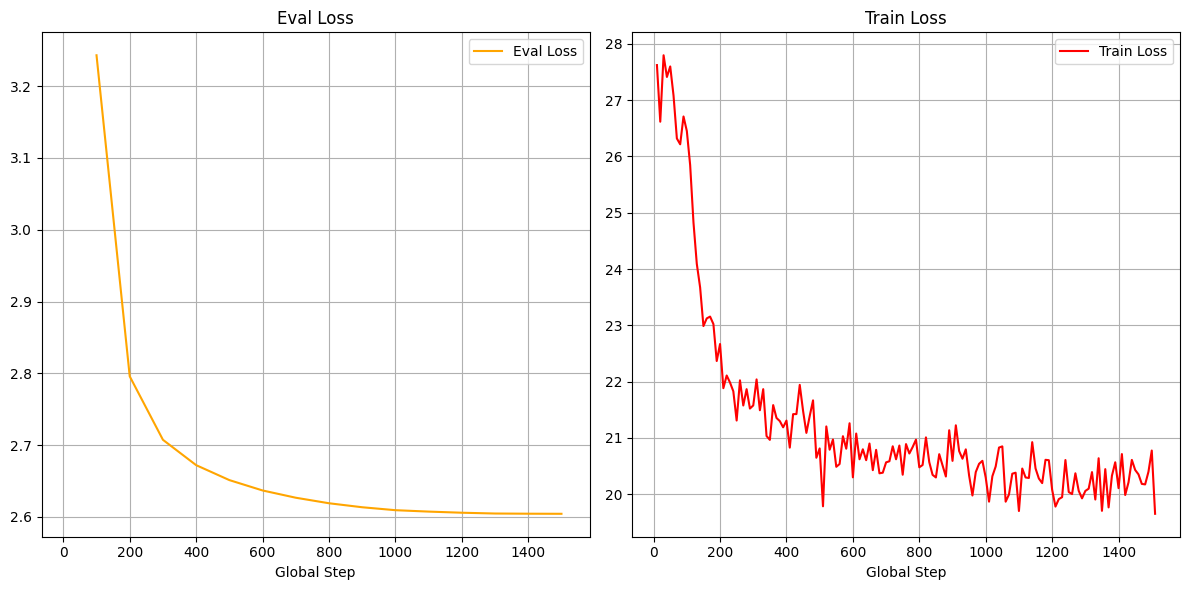

In [ ]:
plot_sft_results('h2by6k9q')

**Evaluation**

In [ ]:
res_ft_790_sft = eval_model(model_790, tokenizer, ['piqa'])
print('Fine tuned: ',res_ft_790_sft['results'])

Mamba 790m fine-tuned with LoRA and SFT:

```
{'piqa': {'alias': 'piqa', 'acc,none': 0.733949945593036, 'acc_stderr,none': 0.010310039263352765, 'acc_norm,none': 0.73449401523395, 'acc_norm_stderr,none': 0.01030330865302444}}
```

#### DPO

In [ ]:
dir_790_dpo = "/content/drive/MyDrive/mamba2/piqa/lora/mamba-790m-piqa-dpo-lora"

params_790m_dpo = PersonalizedParams(
    output_dir=dir_790_dpo,
    eval_steps=200,
    batch_size=2,
    gradient_accumulation_steps=8,
    metric_for_best_model='rewards/accuracies',
    learning_rate=5e-5,
    weight_decay=0.01,
    warmup_ratio=0.1,
    lr_scheduler_type='cosine',
    num_train_epochs=3
)

params_790m_dpo.set_param('fp16', True)

params_790m_dpo

In [ ]:
trainer_790m_dpo = PersonalizedTrainer(
    model = model_790,
    strategy='dpo',
    params=params_790m_dpo,
    early_stopping_patience = 5,
    peft_config=peft_config
)

trainer_790m_dpo

In [ ]:
finetuner_790_dpo = MambaFineTuner(dataset_piqa, trainer_790m_dpo)
finetuner_790_dpo.tune(dir_790_dpo)

Run id: zz098aem

Run duration: 3:28:58
|   Epoch |   Step |   Train Loss |   Eval Loss |
|--------:|-------:|-------------:|------------:|
|  0.1986 |    200 |       0.6766 |      0.6731 |
|  0.3972 |    400 |       0.5872 |      0.5746 |
|  0.5958 |    600 |       0.5185 |      0.5441 |
|  0.7943 |    800 |       0.4855 |      0.5191 |
|  0.9929 |   1000 |       0.5022 |      0.5083 |
|  1.1906 |   1200 |       0.275  |      0.5296 |
|  1.3892 |   1400 |       0.3343 |      0.532  |
|  1.5878 |   1600 |       0.2883 |      0.5363 |
|  1.7864 |   1800 |       0.388  |      0.5381 |
|  1.985  |   2000 |       0.334  |      0.5208 |
|  2.1827 |   2200 |       0.2019 |      0.5743 |
|  2.3813 |   2400 |       0.1822 |      0.585  |
|  2.5799 |   2600 |       0.1808 |      0.5837 |
|  2.7785 |   2800 |       0.2028 |      0.5836 |
|  2.977  |   3000 |       0.1465 |      0.5835 |

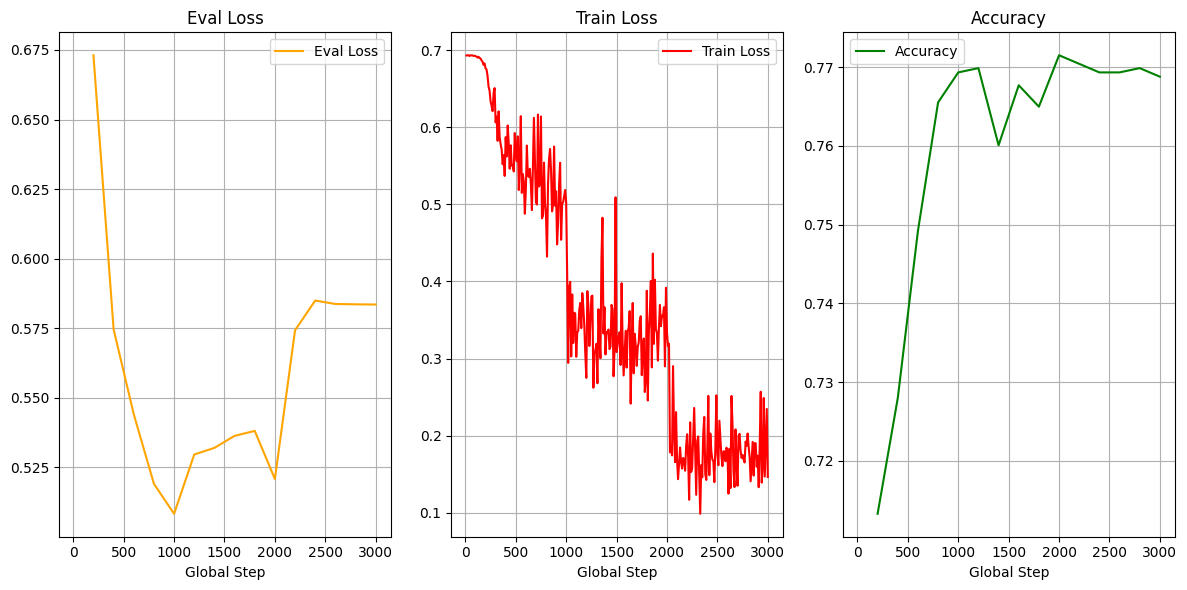

In [ ]:
plot_dpo_results('zz098aem')

**Evaluation**

In [ ]:
res_ft_790_sft = eval_model(model_790, tokenizer, ['piqa'])
print('Fine tuned: ',res_ft_790_sft['results'])

Mamba 790m fine-tuned with LoRA and DPO:

```
{'piqa': {'alias': 'piqa', 'acc,none': 0.7557127312295974, 'acc_stderr,none': 0.010024765172284315, 'acc_norm,none': 0.7698585418933623, 'acc_norm_stderr,none': 0.009820832826839678}}
```

### 1.4b sft

In [ ]:
dir_1400_sft_lora = "/content/drive/MyDrive/mamba2/piqa/lora/mamba-1.4b-piqa-sft-lora"

params_1400m_sft_lora = PersonalizedParams(
    output_dir=dir_1400_sft_lora,
    eval_steps=50,
    save_steps=2,
    batch_size=4,
    gradient_accumulation_steps=16,
    num_train_epochs=3
)
params_1400m_sft_lora.set_param('fp16', True)

params_1400m_sft_lora

In [ ]:
trainer_1400m_sft_lora = PersonalizedTrainer(
    model = model_1400,
    strategy='sft',
    params=params_1400m_sft_lora,
    early_stopping_patience = 5,
    peft_config = peft_config
)

In [ ]:
res_1400_ft_sft_lora = eval_model(model_1400, tokenizer, ['piqa'])
print('Fine tuned:', res_1400_ft_sft_lora['results'])

Mamba 1.4b fine-tuned with LoRA and SFT:

```
{'piqa': {'alias': 'piqa', 'acc,none': 0.7459194776931447, 'acc_stderr,none': 0.010157271999135166, 'acc_norm,none': 0.7464635473340587, 'acc_norm_stderr,none': 0.010150090834551817}}
```

## ARC-E

### 130m

In [ ]:
res_130_arc_e = eval_model(model_130, tokenizer, ['arc_easy'])
print(f'Results base model ({model_130.dtype}): {res_130_arc_e["results"]}')

Results base model (torch.float32):

```
{'arc_easy': {'alias': 'arc_easy', 'acc,none': 0.4797979797979798, 'acc_stderr,none': 0.010251405621305271, 'acc_norm,none': 0.41919191919191917, 'acc_norm_stderr,none': 0.010124905282491126}}
```

In [ ]:
# specifica la directory in base alla strategia di training
dir_130_arce = "/content/drive/MyDrive/mamba2/arce/mamba-130m-arce-sft-text-V2"

#### DPO

In [ ]:
params_130m_dpo = PersonalizedParams(
    output_dir=dir_130_arce,
    eval_steps=40,
    save_steps=3,
    batch_size=16,
)

params_130m_dpo

In [ ]:
trainer_130m_dpo = PersonalizedTrainer(
    model = model_130,
    strategy='dpo',
    params=params_130m_dpo,
    early_stopping_patience = 3
)

trainer_130m_dpo

In [ ]:
finetuner_130_dpo = MambaFineTuner(dataset_arc_e, trainer_130m_dpo)
finetuner_130_dpo.tune(dir_130_arce)

Run id: hy7kx3qm

Run duration: 0:10:13
|   Epoch |   Step |   Train Loss |   Eval Loss |
|--------:|-------:|-------------:|------------:|
|  0.2837 |     40 |       0.6595 |      0.6618 |
|  0.5674 |     80 |       0.6297 |      0.6266 |
|  0.8511 |    120 |       0.6066 |      0.5968 |
|  1.1348 |    160 |       0.2308 |      0.5766 |
|  1.4184 |    200 |       0.2515 |      0.5909 |
|  1.7021 |    240 |       0.2576 |      0.6009 |
|  1.9858 |    280 |       0.183  |      0.585  |

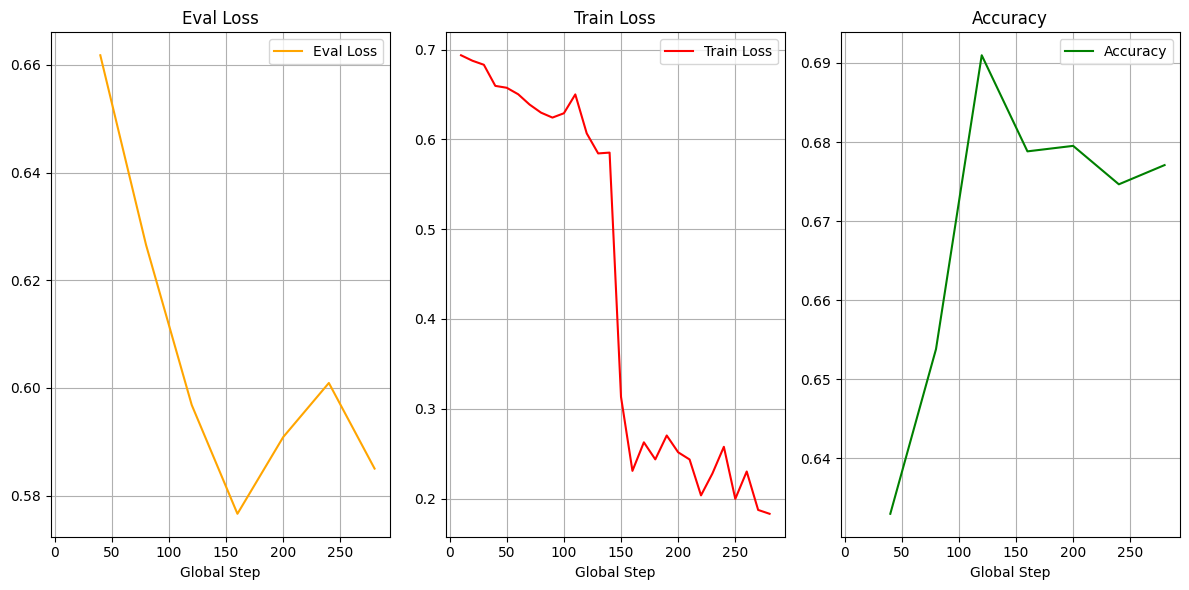

In [ ]:
plot_dpo_results('hy7kx3qm')

**Evaluation**

In [ ]:
model_ft_130_sft = AutoModelForCausalLM.from_pretrained(dir_130_arce)
model_ft_130_sft.to(device)

In [ ]:
res_ft_130_dpo = eval_model(model_130, tokenizer, ['arc_easy'])
print('Fine tuned: ',res_ft_130_dpo['results'])

Mamba 130m fine-tuned with DPO:


```
{{'arc_easy': {'alias': 'arc_easy', 'acc,none': 0.5542929292929293, 'acc_stderr,none': 0.010199118183322836, 'acc_norm,none': 0.5012626262626263, 'acc_norm_stderr,none': 0.010259750807990999}}
}

#### SFT with grid search

We conducted a small grid search over key hyperparameters to optimize fine-tuning in the SFT setting . The process consisted of two iterations of 18 training runs each, where parameters such as learning rate, batch size, and weight decay were systematically varied. This exploration was feasible thanks to the relatively small size of the chosen datasets, which kept both training time and memory requirements manageable, not possibile with larger models in this environment.

As expected, the differences on such a small model were minimal, with variations of no more than 1%.

In [ ]:
# parameters to search
scheduler_params_search =['linear', 'cosine']
learning_rate_search= [2e-05, 3e-05, 4e-05]
weight_decay_search = [0.01, 0.05]
warmup_ratio_search = [0, 0.1, 0.2]

In [ ]:
v = 0
sched = scheduler_params_search[0]
for lr in learning_rate_search:
  for wd in weight_decay_search:
    for wr in warmup_ratio_search:


      v += 1
      dir_130_arce_v = dir_130_arce + '-v' + str(v)

      params_130m_sft = PersonalizedParams(
          output_dir=dir_130_arce_v,
          eval_steps=50,
          batch_size=16,
          load_best_model_at_end = False,
          save_strategy = 'no',
          learning_rate = lr,
          weight_decay = wd,
          warmup_ratio = wr,
          lr_scheduler_type= sched
          )

      params_130m_sft.set_param('fp16', True)
      params_130m_sft.set_param('save_safetensors', False)


      trainer_130m_sft = PersonalizedTrainer(
          model = AutoModelForCausalLM.from_pretrained("state-spaces/mamba-130m-hf", torch_dtype=torch.float32),
          strategy='sft',
          params=params_130m_sft,
          early_stopping_patience = 5
          )

      finetuner_130_sft = MambaFineTuner(dataset_arc_e, trainer_130m_sft)
      finetuner_130_sft.tune(dir_130_arce_v)


In [ ]:
v = 0
sched = scheduler_params_search[0]
for lr in learning_rate_search:
  for wd in weight_decay_search:
    for wr in warmup_ratio_search:
      v+=1
      dir_checkpoint_130_sft = dir_130_arce + '-v' + str(v)
      model_ft_130_sft = AutoModelForCausalLM.from_pretrained(dir_checkpoint_130_sft)
      model_ft_130_sft.to(device)
      res_ft_130_sft = eval_model(model_ft_130_sft, tokenizer, ['arc_easy'])
      print(f"v: {v}, lr: {lr}, wd: {wd}, wr: {wr}, res: {res_ft_130_sft['results']}")

Worst setting:
*   Scheduler_params = cosine
*   Learning_rate =2e-05
*   Voce weight_decay = 0.01
*   Warmup_ratio = 0.1

Accuracy = 51,17%

---

Best setting:
*   Scheduler_params = linear
*   Learning_rate =4e-05
*   Voce weight_decay = 0.01
*   Warmup_ratio = 0.2

Accuracy = 52,14%

### 370m

In [ ]:
res_370_arc_e = eval_model(model_370, tokenizer, ['arc_easy'])
print(f'Risultati modello base ({model_370.dtype}): {res_370_arc_e["results"]}')

Results base model (torch.float32):
```
{'arc_easy': {'alias': 'arc_easy', 'acc,none': 0.5496632996632996, 'acc_stderr,none': 0.010209047724374136, 'acc_norm,none': 0.4819023569023569, 'acc_norm_stderr,none': 0.010253060653479045}}

In [ ]:
# specifica la directory in base alla strategia di training
dir_370_arce = "/content/drive/MyDrive/mamba2/arce/mamba-370m-arce-dpo-v3"

#### SFT

In [ ]:
params_370m_sft = PersonalizedParams(
    output_dir=dir_370_arce,
    eval_steps=80,
    save_steps=2,
    batch_size=4,
    gradient_accumulation_steps=2
)

params_370m_sft

In [ ]:
trainer_370m_sft = PersonalizedTrainer(
    model = model_370,
    strategy='sft',
    params=params_370m_sft,
    early_stopping_patience = 3
)

trainer_370m_sft

In [ ]:
finetuner_370_sft = MambaFineTuner(dataset_arc_e, trainer_370m_sft)
finetuner_370_sft.tune(dir_370_arce)

Run id: 5ogryn61

Run duration: 0:14:03
|   Epoch |   Step |   Train Loss |   Eval Loss |
|--------:|-------:|-------------:|------------:|
|  0.2842 |     80 |       4.913  |      2.5875 |
|  0.5684 |    160 |       5.0187 |      2.506  |
|  0.8526 |    240 |       4.8491 |      2.4709 |
|  1.135  |    320 |       3.4722 |      2.5197 |
|  1.4192 |    400 |       3.5176 |      2.5304 |
|  1.7034 |    480 |       3.436  |      2.5432 |

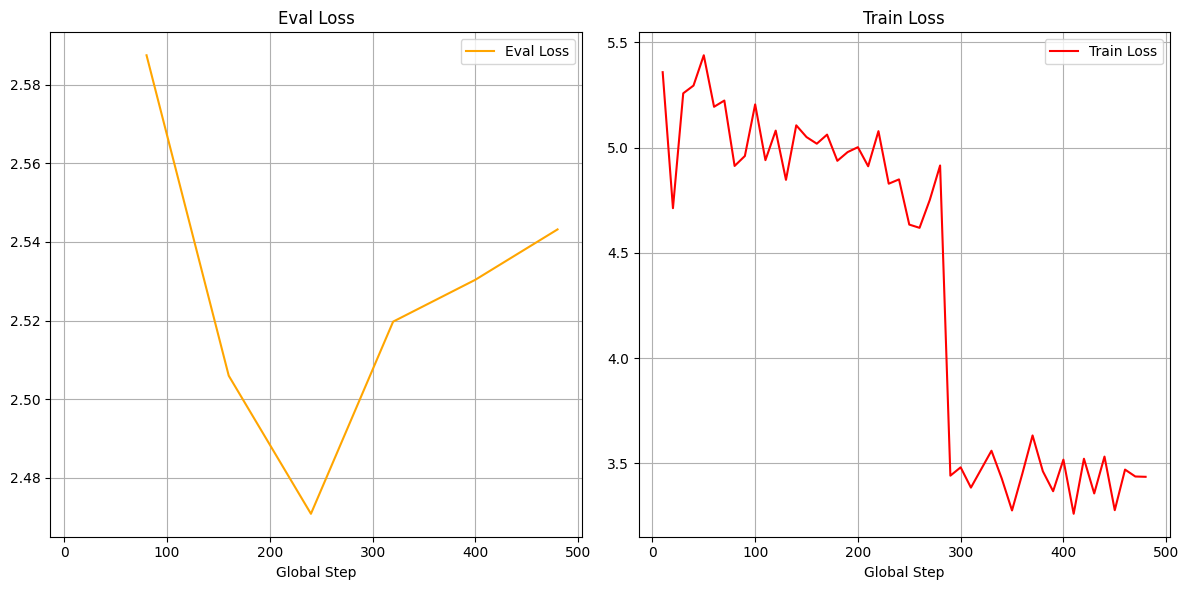

In [ ]:
plot_sft_results('5ogryn61')

**Evaluation**

In [ ]:
res_ft_370_sft = eval_model(model_370, tokenizer, ['arc_easy'])
print('Fine tuned: ',res_ft_370_sft['results'])

Running loglikelihood requests: 100%|██████████| 9501/9501 [12:53<00:00, 12.28it/s]


Fine tuned:  {'arc_easy': {'alias': 'arc_easy', 'acc,none': 0.5904882154882155, 'acc_stderr,none': 0.010090368160989927, 'acc_norm,none': 0.5681818181818182, 'acc_norm_stderr,none': 0.010163945352271771}}


Mamba 370m fine-tuned with SFT:

```
{'arc_easy': {'alias': 'arc_easy', 'acc,none': 0.5904882154882155, 'acc_stderr,none': 0.010090368160989927, 'acc_norm,none': 0.5681818181818182, 'acc_norm_stderr,none': 0.010163945352271771}}}

#### DPO




In [ ]:
params_370m_dpo = PersonalizedParams(
    output_dir=dir_370_arce,
    eval_steps=200,
    save_steps=2,
    batch_size=2,
    gradient_accumulation_steps=4,
    learning_rate=5e-05,
    weight_decay=0.01,
    warmup_ratio=0.05,
    lr_scheduler_type = 'cosine',

)

params_370m_dpo

PersonalizedParams(
  eval_steps=200,
  eval_strategy='steps',
  gradient_accumulation_steps=4,
  learning_rate=5e-05,
  load_best_model_at_end=True,
  lr_scheduler_type='cosine',
  metric_for_best_model='eval_loss',
  num_train_epochs=3,
  output_dir='/content/drive/MyDrive/mamba2/arce/mamba-370m-arce-dpo-v3',
  per_device_eval_batch_size=2,
  per_device_train_batch_size=2,
  report_to='wandb',
  save_safetensors=False,
  save_steps=400,
  save_strategy='steps',
  save_total_limit=1,
  warmup_ratio=0.05,
  weight_decay=0.01,
)

In [ ]:
trainer_370m_dpo = PersonalizedTrainer(
    model = model_370,
    strategy='dpo',
    params=params_370m_dpo,
    early_stopping_patience = 3
)

trainer_370m_dpo

PersonalizedTrainer(
  model=state-spaces/mamba-370m-hf,(dtype=torch.float32)
  strategy='dpo',
  early_stopping_patience=3
  peft_config=None
)

In [ ]:
finetuner_370_dpo = MambaFineTuner(new_dataset_arc_e, trainer_370m_dpo)
finetuner_370_dpo.tune(save=dir_370_arce)

Run id: nh58yhvw

Run duration: 0:43:34
|   Epoch |   Step |   Train Loss |   Eval Loss |   Eval Accuracy |
|--------:|-------:|-------------:|------------:|----------------:|
|  0.2485 |    200 |       0.147  |      1.0173 |          0.7688 |
|  0.497  |    400 |       0.4739 |      1.1987 |          0.7803 |
|  0.7456 |    600 |       0.5761 |      1.2205 |          0.7773 |
|  0.9941 |    800 |       0.6993 |      1.2547 |          0.7682 |

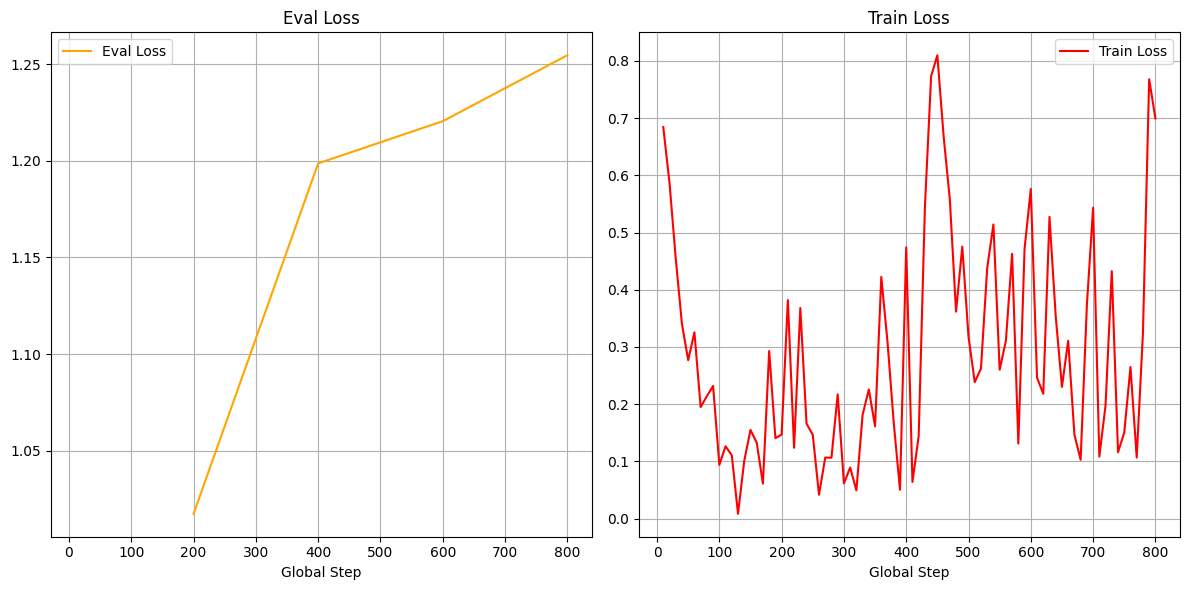

In [ ]:
plot_dpo_results('nh58yhvw')

**Evaluation**

In [ ]:
res_ft_370_dpo = eval_model(model_370, tokenizer, ['arc_easy'])
print('Fine tuned: ',res_ft_370_dpo['results'])

Mamba 370m fine-tuned with DPO:

```
{'arc_easy': {'alias': 'arc_easy', 'acc,none': 0.6069023569023569, 'acc_stderr,none': 0.010022540618945322, 'acc_norm,none': 0.6056397306397306, 'acc_norm_stderr,none': 0.010028176038392816
}}

### 790m


In [ ]:
res_790_arc_e = eval_model(model_790, tokenizer, ['arc_easy'])
print(f'Risultati modello base ({model_790.dtype}): {res_790_arc_e["results"]}')





Results base model (torch.float32):
```
{'arc_easy': {'alias': 'arc_easy', 'acc,none': 0.6123737373737373, 'acc_stderr,none': 0.009997307914447627, 'acc_norm,none': 0.5382996632996633, 'acc_norm_stderr,none': 0.010229639820610701}}

#### SFT


In [ ]:
dir_790_sft_arce = "/content/drive/MyDrive/mamba2/mamba-790m-arce-sft-v2"

params_790m_sft = PersonalizedParams(
    output_dir=dir_790_sft_arce,
    eval_steps=50,
    save_steps=2,
    batch_size=4,
    gradient_accumulation_steps=2,
    learning_rate=4e-05,
    weight_decay=0.01,
    warmup_ratio=0.05,
    lr_scheduler_type = 'cosine',

)

params_790m_sft

In [ ]:
trainer_790m_sft = PersonalizedTrainer(
    model = model_790,
    strategy='sft',
    params=params_790m_sft,
    early_stopping_patience = 3
)

trainer_790m_sft

In [ ]:
finetuner_790_sft = MambaFineTuner(new_dataset_arc_e, trainer_790m_sft)
finetuner_790_sft.tune(save=dir_790_sft_arce)

Run id: t6z0sbp8

Run duration: 0:44:26
|   Epoch |   Step |   Train Loss |   Eval Loss |
|--------:|-------:|-------------:|------------:|
|  0.1776 |     50 |       5.7228 |      2.8669 |
|  0.3552 |    100 |       5.5352 |      2.694  |
|  0.5329 |    150 |       5.2522 |      2.619  |
|  0.7105 |    200 |       5.2319 |      2.5744 |
|  0.8881 |    250 |       4.8375 |      2.5443 |
|  1.0639 |    300 |       4.7256 |      2.5218 |
|  1.2416 |    350 |       4.5013 |      2.5097 |
|  1.4192 |    400 |       4.7768 |      2.5004 |
|  1.5968 |    450 |       4.594  |      2.4945 |
|  1.7744 |    500 |       4.6066 |      2.4922 |
|  1.952  |    550 |       4.6453 |      2.4887 |
|  2.1279 |    600 |       4.357  |      2.4867 |
|  2.3055 |    650 |       4.4674 |      2.4847 |
|  2.4831 |    700 |       4.5862 |      2.486  |
|  2.6607 |    750 |       4.5147 |      2.4857 |
|  2.8384 |    800 |       4.5844 |      2.4867 |

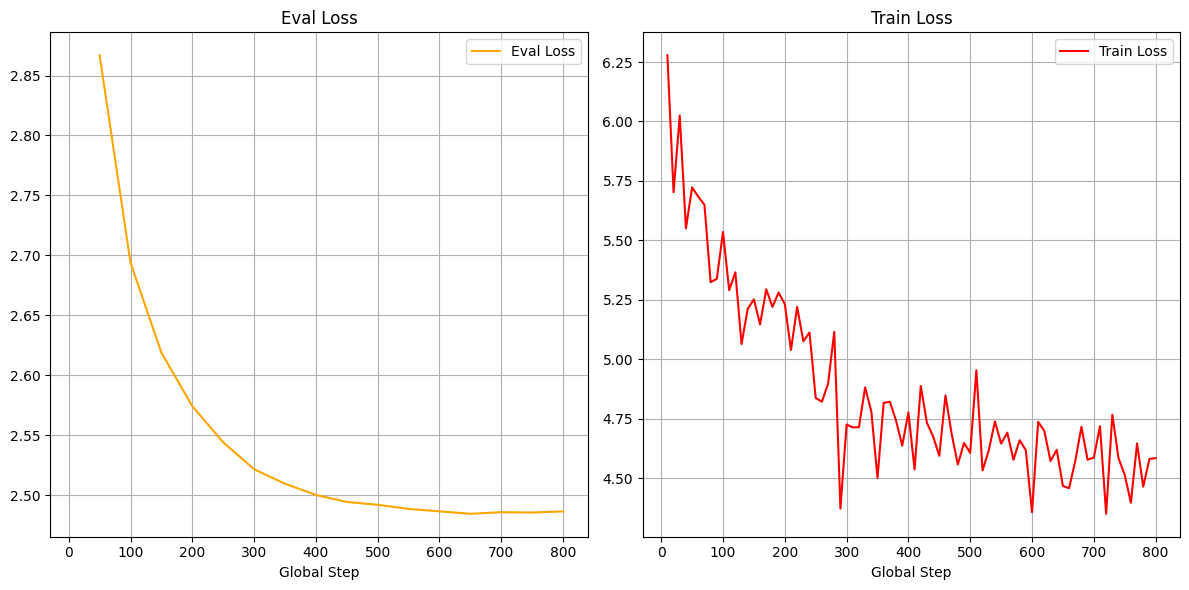

In [ ]:
plot_sft_results('t6z0sbp8')

**Evaluation**

In [ ]:
res_790 = eval_model(model_790, tokenizer, ['arc_easy'])
print('Fine tuned: ',res_790['results'])

Mamba 790m fine-tuned with SFT:

```
{'arc_easy': {'alias': 'arc_easy', 'acc,none': 0.6372053872053872, 'acc_stderr,none': 0.009865936757013891, 'acc_norm,none': 0.6279461279461279, 'acc_norm_stderr,none': 0.009918187193096445}}


#### DPO

In [ ]:
dir_790_sft_arce = "/content/drive/MyDrive/mamba2/mamba-790m-arce-dpo-v2"

params_790m_dpo = PersonalizedParams(
    output_dir=dir_790_sft_arce,
    eval_steps=250,
    save_steps=2,
    batch_size=2,
    gradient_accumulation_steps=4,
    learning_rate=4e-05,
    weight_decay=0.01,
    warmup_ratio=0.05,
    lr_scheduler_type = 'cosine',
    metric_for_best_model='rewards/accuracies'
)


params_790m_dpo.set_param('save_safetensors', False)

params_790m_dpo

In [ ]:
trainer_790m_dpo = PersonalizedTrainer(
    model = model_790,
    strategy='dpo',
    params=params_790m_dpo,
    early_stopping_patience = 3
)

trainer_790m_dpo

In [ ]:
finetuner_790_dpo = MambaFineTuner(new_dataset_arc_e, trainer_790m_dpo)
finetuner_790_dpo.tune(save=dir_790_sft_arce)

Run id: zel4v4l7

Run duration: 1:42:18.269766
|   Epoch |   Step |   Train Loss |   Eval Loss |   Eval Accuracy |
|--------:|-------:|-------------:|------------:|----------------:|
|  0.3107 |    250 |       0.5553 |      0.5788 |          0.7718 |
|  0.6213 |    500 |       0.2843 |      0.4394 |          0.8161 |
|  0.932  |    750 |       0.1842 |      0.414  |          0.8307 |
|  1.2423 |   1000 |       0.1187 |      0.4016 |          0.8301 |
|  1.553  |   1250 |       0.0802 |      0.4021 |          0.8295 |
|  1.8636 |   1500 |       0.0686 |      0.401  |          0.8307 |

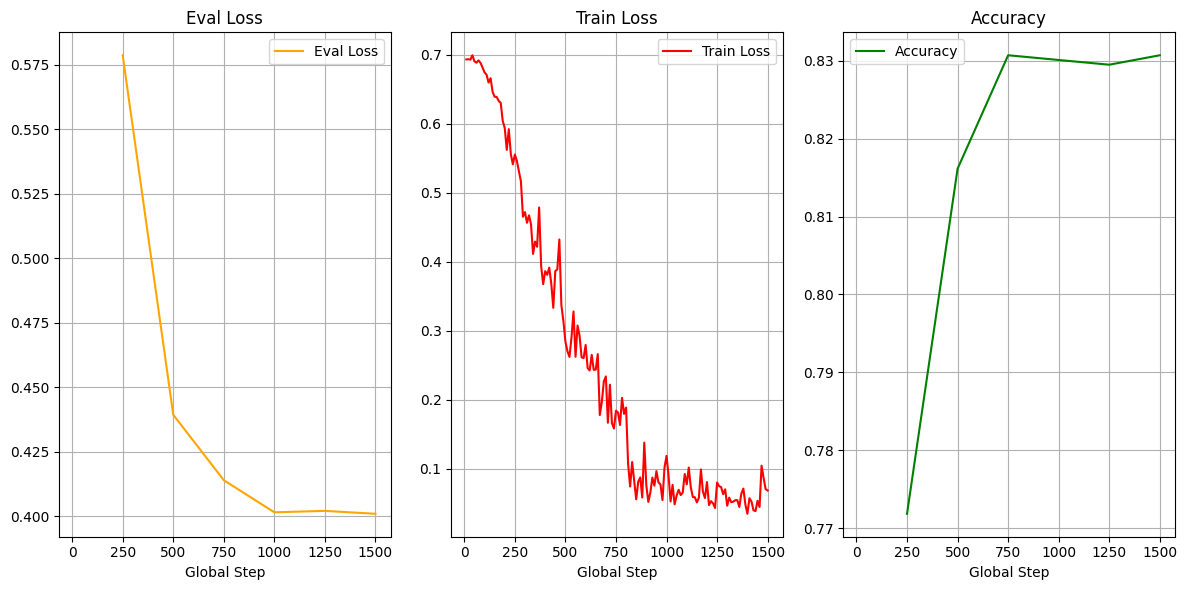

In [ ]:
plot_dpo_results('zel4v4l7')

**Evaluation**

In [ ]:
res_ft_790_dpo = eval_model(finetuner_790_dpo, tokenizer, ['arc-easy'])
print('Fine tuned: ',res_ft_790_dpo['results'])

Mamba 790m fine-tuned with DPO:

```
{}

### 1.4b sft

In [ ]:
dir_1400_sft_lora = "/content/drive/MyDrive/mamba2/arce/mamba-1.4b-piqa-sft-lora"

params_1400m_sft_lora = PersonalizedParams(
    output_dir=dir_1400_sft_lora,
    eval_steps=50,
    save_steps=2,
    batch_size=4,
    gradient_accumulation_steps=16,
    num_train_epochs=3
)
params_1400m_sft_lora.set_param('fp16', True)

params_1400m_sft_lora

In [ ]:
trainer_1400m_sft_lora = PersonalizedTrainer(
    model = model_1400,
    strategy='sft',
    params=params_1400m_sft_lora,
    early_stopping_patience = 5,
    peft_config = peft_config
)

In [ ]:
res_1400_ft_sft_lora = eval_model(model_1400, tokenizer, ['arc_easy'])
print('Fine tuned:', res_1400_ft_sft_lora['results'])

Mamba 1.4b fine-tuned with LoRA and SFT:

```
{'piqa': {'alias': 'piqa', 'acc,none': 0.7459194776931447, 'acc_stderr,none': 0.010157271999135166, 'acc_norm,none': 0.7464635473340587, 'acc_norm_stderr,none': 0.010150090834551817}}
```

# Results and final comments

Full results table can be found [here](https://docs.google.com/spreadsheets/d/1BP_IjWKOd1V5yaf_Is5UwXBkKpxoxz7bTbljlQgRaKo/edit?gid=1864727609#gid=1864727609)

We focus here on a subset of results relevant to our initial experimental goals.

## PIQA

**Full Fine-Tuning**

| Model      | Dtype | Trainer | Accuracy (base) | Accuracy (FT) |
| ---------- | ----- | ------- | --------------- | ------------- |
| mamba 130m | bf16  | SFT     | 64.47%          | 67.35%        |
| mamba 130m | bf16  | DPO     | 64.47%          | 65.13%        |
| mamba 130m | fp32  | SFT     | 64.47%          | 68.06%        |
| mamba 130m | fp32  | DPO     | 64.47%          | 68.44%        |
| mamba 370m | fp32  | SFT     | 69.47%          | 73.12%        |
| mamba 370m | fp32  | DPO     | 69.47%          | 76.17%        |
| mamba 790m | bf16  | SFT     | 72.14%          | 73,39%        |
| mamba 790m | bf16  | DPO     | 72.14%          | 75,35%             |

The best model we were able to train is the 370 million parameters Mamba, that, fine-tuned with the DPO Trainer, got better results than the Mamba 2.8 billion parameters, the biggest Mamba model.

The Mamba 370M fine-tuned with DPO results are even comparable with Mamba2 2.7 billion parameters. Again, the biggest Mamba2 model.

The mamba 790M here was our upper bound due to the environment constraint. We had to rely on the `torch.bfloat16` precision and we could not try much hyperparameters search.

**LoRA Fine-Tuning**

|Model|Dtype|Trainer|Accuracy (base)|Accuracy (FT)|
|---|---|---|---|---|
|mamba 130m|fp32|SFT|64.47%|65.20%|
|mamba 130m|fp32|DPO|64.47%|65.56%|
|mamba 370m|fp32|SFT|69.47%|70.95%|
|mamba 370m|fp32|DPO|69.47%|70.73%|
|mamba 370m|fp32|DPO|69.47%|71.23%|
|mamba 790m|fp32|SFT|72.14%|73.39%|
|mamba 790m|fp32|DPO|72.14%|75.57%|
|mamba 1.4b|bf16|SFT|74.16%|74.59%|

**Observations**

In our experiments, we explored both SFT with completion datasets—where the loss is calculated only on the completion portion of each sequence—and standard text-based datasets, which use cross-entropy loss over the entire sequence. We observed that the text-based approach consistently yielded slightly better results, and therefore it was adopted for the subsequent experiments.

The most significant performance gains on PIQA were achieved with the DPO approach. Unlike SFT, which trains the model only on the correct answers, DPO provides both correct and incorrect options, allowing the model to learn by comparison. This comparative learning mechanism proved particularly effective, although we noted that training with DPO often led to overfitting: training loss decreased sharply while validation loss increased, typically near the end of each epoch. Despite this, DPO consistently outperformed SFT, achieving higher final accuracies, though at the cost of longer training times—roughly three times slower than SFT in our experiments.

Hyperparameter tuning played a critical role in maximizing performance. Adjustments to learning rate, weight decay (with an effective value around 0.01), and warmup (approximately 10% ± 5%) produced noticeable improvements. The choice of evaluation metric also depended on the training strategy. For SFT, we relied on validation loss to select the best model, as it reflects the model's ability to generalize from training data. For DPO, we primarily monitored the rewards/accuracies metric, which measures the fraction of chosen rewards that exceed rejected rewards, while also keeping an eye on validation loss and reward margins to track overfitting and the model's discrimination between correct and incorrect responses.

Several important insights emerged from our LoRA experiments. In terms of training efficiency, we observed that LoRA required roughly the same time per epoch as full fine-tuning, while substantially reducing memory consumption. This efficiency gain was particularly valuable, as it enabled us to fine-tune larger models, such as the Mamba 1.4B, even within the constraints of the Colab environment. Another notable advantage was the dramatic reduction in checkpoint size compared to full fine-tuning, which made storage and model management considerably easier. Regarding model size and effectiveness, we found that LoRA produced limited improvements on smaller models, such as the 130M and 370M variants. However, as model size increased to 790M and 1.4B, the benefits of LoRA became much more apparent, indicating that this method scales more effectively with larger architectures.
For example the Mamba 790M fine tuned with LoRA and DPO achieved a better result than the Mamba 790M full fine-tuned.
For small models the results obtained with LoRA are not comparable with the results obtained with the full fine tuning, while for bigger models results are even better than the full fine tuning.

## ARC-E

**Full Fine-Tuning**

| Model       | Trainer    | Accuracy (base) | Accuracy (FT) |
|-------------|-----------|-----------------|---------------|
| mamba 130m  | SFT       | 47.98%          | 51.77%        |
| mamba 130m  | DPO       | 47.98%          | 51.98%        |
| mamba 130m  | DPO  v2   | 47.98%          | 55,42%        |
| mamba 370m  | SFT       | 54.97%          | 59.04%        |
| mamba 370m  | DPO       | 54.9%           | 55.60%        |
| mamba 370m  | DPO v2    | 54.97%           | 60.69%        |
| mamba 790m  | SFT       | 60.43%          | 63.72%        |
| mamba 790m  | DPO v2    | 60.43%          | 67.34%        |

**Observations**

For the ARC-E dataset, we restricted our experiments to `torch.float32` precision. Given the relatively small size of the dataset, memory constraints were not an issue, which allowed us to avoid the trade-offs associated with reduced precision. As in the PIQA experiments, we adopted the text-based SFT approach with cross-entropy loss applied across the entire sequence, since it consistently yielded better results compared to completion-based training.

The baseline DPO setup generally performed worse—or at best comparable—to SFT, suggesting that the benefits of preference-based training are less pronounced for this dataset.
However, with the refined DPO v2 configuration, we observed a noticeable improvement. That said, the impact of DPO v2 varied depending on model size. For smaller models such as Mamba 130M and 370M, SFT remained the more effective and efficient option, achieving equal or superior performance with shorter training times. By contrast, in larger models such as Mamba 790M, DPO v2 outperformed SFT, albeit at the cost of substantially longer training times. This indicates that while SFT is generally the more practical choice for smaller architectures, preference-based training methods like DPO v2 become increasingly advantageous as model scale increases.

**Final Comments**

This work demonstrates that fine-tuning can substantially reduce the computational and memory requirements needed to achieve competitive performance on benchmark datasets. Notably, we showed that the Mamba 370M model—occupying approximately 1.5 GB—was able to match or even surpass the performance of the much larger 2.8B model, which requires around 11 GB. This result highlights the potential of fine-tuned smaller models to serve as practical alternatives to significantly larger architectures.

The consistency of these findings across experiments further strengthens this claim. In most cases, fine-tuning allowed a model to reach or exceed the performance of the next tier in parameter size: the fine-tuned Mamba 130M achieved results comparable to the baseline 370M, the 370M matched the 790M, and the 790M reached the level of the 1.4B and 2.8B models. Such outcomes underscore the effectiveness of fine-tuning as a strategy for enhancing model efficiency without the need for additional parameters.

These results point to an important insight: the choice of fine-tuning technique often matters more than raw model size. Even within the constraints of a limited environment such as Google Colab, carefully selected fine-tuning strategies enabled us to unlock significant performance gains, making it possible to deploy capable models on less powerful hardware without compromising accuracy or efficiency.

# Future work

## Mamba 2

A direction for future work is a deeper exploration of **Mamba 2**, the next-generation state space model architecture. Unlike its predecessor, Mamba 2 leverages the principle of State Space Duality (SSD), where the state transition matrix is reduced to a scalar-times-identity form. This simplification not only preserves the ability to model long-range dependencies but also enables 2-8× faster computation compared to the original design.

The architecture further introduces parallel parameter computation, grouped projections, and efficient tensor parallelism, all of which enhance scalability in resource-constrained environments. These innovations suggest that Mamba 2 could be an even stronger candidate for fine-tuning and deployment on limited hardware, while maintaining competitiveness with Transformer-based approaches.

**SSD** is a theoretical framework that shows how state space models (SSMs) and attention mechanisms can be seen as two dual forms of the same underlying computation. This type of approach is very useful because the development of SSMs haven appeared disjoint from the scientific community’s collective effort to improve Transformers, such as understanding them theoretically as well as optimizing them on modern hardware.

From a computational standpoint, despite the work that went into making Mamba fast (in particular, its hardware-aware selective scan implementation) it’s still much less hardware-efficient than mechanisms such as attention. The missing piece is that modern accelerators such as GPUs and TPUs are highly specialized for matrix multiplications. As a result, it is more difficult to understand and experiment with
SSMs compared to Transformers, and it remains challenging to train SSMs as efficiently as Transformers from both an
algorithmic and systems perspective.

With SSD the progress are far more linked and many optimization tricks intended for Transformes could be availabel for Mamba 2 models. This duality allows new capabilities such as
the ability to have both efficient parallelizable training and efficient autoregressive inference.

This is possible through the use of semi-separable matrices, a type of structured matrix that can be expressed as the outer product of two vectors or as the product of two (or more) lower-rank matrices.

Given a matrix $A \in \mathbb{R}^{m \times n}$ is separable.
It is separable if it can be written as:

$$
A = u v^\top
$$

where

$$
u \in \mathbb{R}^m, \quad v \in \mathbb{R}^n
$$

In practice, instead of storing the entire matrix, it is sufficient to store the two vectors.  

This idea is generalized with **low-rank decomposition**, where a large separable matrix  $A \in \mathbb{R}^{m \times n}$ can be approximated by two smaller matrices $U \in \mathbb{R}^{m \times r} $ and $V \in \mathbb{R}^{n \times r}$ with $r \ll \min(m,n)$

$$
A \approx U V^\top
$$


**Semiseparable Matrices in Mamba-2**

A State Space Model (SSM) defines a sequence transformation that maps $x \in \mathbb{R}^T$ to $y \in \mathbb{R}^T$ via a linear operator:

$$
y = SSM(A,B,C)(x) = M x,
$$

where $M \in \mathbb{R}^{T \times T}$ represents the full matrix of the sequence transformation. In general, storing or multiplying by $M$ directly would cost $O(T^2)$ in memory and computation.

A standard separable matrix can be written as a single outer product:

$$
A = u v^\top, \quad u \in \mathbb{R}^m, \; v \in \mathbb{R}^n
$$

A **semiseparable matrix** generalizes this idea to sequences, allowing each entry in the lower-triangular part of \(M\) to be written as a product of smaller matrices or vectors along the sequence:

$$
M_{ji} = C_j^\top A_j A_{j-1} \cdots A_{i+1} B_i, \quad j \ge i
$$

This allows Mamba-2 to perform sequence transformations efficiently without storing the full matrix.

- Separable: single outer product → one vector for rows, one for columns.  
- Semiseparable: sequence of outer-product-like terms → each submatrix has low rank, and the structure carries through the sequence.

$$
M_{ji} = a_j a_{j-1} \cdots a_i, \quad j \ge i
$$


Specifically, $M$ is called **N-semiseparable** if every submatrix in its lower-triangular portion has rank at most $N$. This property allows a **Sequentially Semiseparable (SSS)** representation of the form:

$$
M_{ji} = C_j^\top A_j A_{j-1} \cdots A_{i+1} B_i,
$$

where $A_i \in \mathbb{R}^{N \times N}$ and $B_i, C_j \in \mathbb{R}^{N}$. In this representation, the full $T \times T$ matrix $M$ is reconstructed from only $O(NT)$ parameters instead of $O(T^2)$.  

In the special case of a scalar SSM with state size $N = 1$, each $A_i, B_i, C_j$ becomes a scalar, and the SSS representation reduces to a **1-semiseparable (1-SS) matrix**:

$$
M_{ji} = a_{j:i},
$$

where $a_{j:i}$ denotes the cumulative product over the sequence from $i$ to $j$. Multiplication by $M$ then corresponds to a cumulative recurrence:

$$
y_t = a_t y_{t-1} + x_t,
$$

which can be computed in linear time $O(T)$, avoiding the quadratic complexity of the full matrix multiplication.  

Mamba-2 leverages this equivalence: instead of explicitly constructing $M$, the model stores the small matrices or scalars $(A_i, B_i, C_i)$ and computes the forward pass through **efficient semiseparable matrix operations**. This allows Mamba-2 to perform sequence transformations exactly while maintaining linear-time complexity $O(NT)$ and memory usage, even for very long sequences. In essence, SSMs and their semiseparable representations are used interchangeably in Mamba-2, forming the theoretical backbone for fast, structured sequence modeling.










**Semiseparable Matrices in Mamba-2 and Attention**

In Mamba-2, state space models (SSMs) are represented as lower-triangular **semiseparable matrices**, which allow sequence transformations to be computed efficiently in linear time. This is closely analogous to **causal attention**: in linear attention, a sequence is multiplied by a lower-triangular mask, which is equivalent to a cumulative sum along the sequence. Similarly, multiplying by the semiseparable SSM matrix implements a structured recurrence across the sequence. The key intuition is that Mamba-2 performs an “attention-like” operation, where the transformation weights are implicitly encoded in the semiseparable matrix, giving the benefits of attention flexible sequence interactions while maintaining **linear-time computation and a compact, structured representation**.


**Mamba 2 Architecture**

Although the core contribution of **Mamba-2** lies in the  Space Duality (SSD) framework, the architecture introduces some minor but impactful structural changes compared to its predecessor.

The primary modification is the **parallel computation of the SSM parameters** $(A, B, C)$ alongside the input $X$, rather than generating them sequentially. This change is partly inspired by the connection to attention mechanisms, but it is also more practical: it simplifies the block structure and makes the architecture more amenable to **scaling techniques** such as tensor parallelism, as will be discussed in Part IV of this series.

By connecting SSMs and attention, the SSD framework provides a shared vocabulary and library of techniques applicable to both. This allows ideas originally developed for Transformers—such as parallel projections, normalization layers, and multi-head mechanisms—to inform the design of Mamba-2 blocks.

In **Mamba-1**, the SSM parameters $(A, B, C)$ were computed as functions of the SSM input $X$. Concretely, the linear projections defining $(A, B, C)$ occurred after the initial projection to create $X$.  

In **Mamba-2**, the SSD layer is viewed as a map:

$$
(A, X, B, C) \mapsto Y
$$

This perspective naturally motivates computing $(A, B, C)$ in parallel with $X$ at the start of the block. This mirrors the standard attention formulation, where queries $Q$, keys $K$, and values $V$ are all produced in parallel.  

Adopting parallel projections for $(A, B, C, X)$ has several advantages:

- Slightly reduces the total number of parameters.
- Simplifies scaling to larger models using **tensor parallelism**, a method for distributing the computation of a single large neural network layer across multiple devices.

Mamba-2 includes an extra normalization layer to improve training stability, especially in larger models. Unlike standard approaches that normalize before transformations, Mamba-2 applies normalization after the multiplicative gate branch, meaning after the element-wise gating operation, which helps stabilize training while preserving the efficiency of the sequence transformation.

These modifications, while minor relative to the SSD theory, make **Mamba-2 blocks simpler, more robust, and easier to scale**.

<figure>
<img src='https://www.ibm.com/content/dam/connectedassets-adobe-cms/worldwide-content/creative-assets/s-migr/ul/g/9a/99/mamba-block-2.component.crop-1by1-l.ts=1751997596660.png/content/adobe-cms/us/en/think/topics/mamba-model/jcr:content/root/table_of_contents/body-article-8/image_601882237' width=60%>

<figcaption>Image from 6.</figcaption>
</figure>
<!-- ![Image from 6.](mamba-block2.png)
_Image from 6._ -->

## New Trainers



Another important direction for future work is to extend fine-tuning beyond supervised and preference-based approaches by exploring reinforcement learning-based methods, such as GRPO and PPO. These techniques allow models to align more closely with human preferences and task-specific objectives by optimizing behavior through reward signals rather than static datasets.

**GRPO** is an online learning algorithm that iteratively improves by using data generated by the model itself during training. Its objective is to maximize the advantage of the model’s generated completions—while ensuring the policy stays close to the reference—providing a balanced approach to exploration and stability. Meanwhile, **PPO** is a robust, policy-gradient method that enhances learning stability by introducing a clipped surrogate objective, which limits how much the model’s policy can change in each update.

Investigating their integration with Mamba and Mamba 2 could provide valuable insights into how state space architectures respond to reinforcement-driven optimization, and whether their efficiency advantages also hold in more complex training paradigms

# References

1. Albert Gu, Tri Dao. 1 Dec 2023. *"Mamba: Linear-Time Sequence Modeling with Selective State Spaces"*. [arxiv 2312.00752](https://arxiv.org/abs/2312.00752).
2. AI Coffee Break with Letitia. 17 Feb 2024. "[MAMBA and State Space Models explained | SSM explained](https://youtu.be/vrF3MtGwD0Y)". YouTube.
3. Algorithmic Simplicity. 1 May 2024."[MAMBA from Scratch: Neural Nets Better and Faster than Transformers](https://www.youtube.com/watch?v=N6Piou4oYx8&t=1313s)". YouTube.
4. Yannic Kilcher. 24 Dec 2023. "[Mamba: Linear-Time Sequence Modeling with Selective State Spaces (Paper Explained)](https://www.youtube.com/watch?v=9dSkvxS2EB0)". YouTube.
5. Maarten Grootendorst."[A Visual Guide to Mamba and State Space Models](https://newsletter.maartengrootendorst.com/p/a-visual-guide-to-mamba-and-state)". Last accessed: 2 Sep 2025.
6. Dave Bergmann. [What is a Mamba Model?|IBM](https://www.ibm.com/think/topics/mamba-model). Last access 5 Sep 2025.
7. Nvidia Developer. "[Scan algorithm (NVIDIA)](https://developer.nvidia.com/gpugems/gpugems3/part-vi-gpu-computing/chapter-39-parallel-prefix-sum-scan-cuda)". Last access 15 Jul 2025.
8. Stella Biderman, Hailey Schoelkopf, Lintang Sutawika, Leo Gao, Jonathan Tow, Baber Abbasi, Alham Fikri Aji, Pawan Sasanka Ammanamanchi, Sidney Black, Jordan Clive, Anthony DiPofi, Julen Etxaniz, Benjamin Fattori, Jessica Zosa Forde, Charles Foster, Jeffrey Hsu, Mimansa Jaiswal, Wilson Y. Lee, Haonan Li, Charles Lovering, Niklas Muennighoff, Ellie Pavlick, Jason Phang, Aviya Skowron, Samson Tan, Xiangru Tang, Kevin A. Wang, Genta Indra Winata, François Yvon, Andy Zou. *"Lessons from the Trenches on Reproducible Evaluation of Language Models*". 29 May 2024. [arxiv 2405.14782](https://arxiv.org/abs/2405.14782)
9. Eluther AI. [Evaluating LLMs](https://www.eleuther.ai/projects/large-language-model-evaluation). Last access: 31 Aug 2025.
10. Eluther AI. [GitHub lm-evaluation-harness](https://github.com/EleutherAI/lm-evaluation-harness). Last access: 31 Aug 2025.
11. Hugging Face. [SFT Trainer](https://huggingface.co/docs/trl/sft_trainer). Last access: 27 Aug 2025.
12. Hugging Face. [DPO Trainer](https://huggingface.co/docs/trl/en/dpo_trainer). Last access: 27 Aug 2025.
13. Rafael Rafailov, Archit Sharma, Eric Mitchell, Stefano Ermon, Christopher D. Manning, Chelsea Finn. 29 Jul 2024. *"# Direct Preference Optimization: Your Language Model is Secretly a Reward Model"*. [arxiv 2305.18290](https://arxiv.org/abs/2305.18290).
14. Hugging Face. [LoRA](https://huggingface.co/docs/peft/main/conceptual_guides/lora). Last access: 28 Aug 2025.
15. Edward J. Hu, Yelong Shen, Phillip Wallis, Zeyuan Allen-Zhu, Yuanzhi Li, Shean Wang, Lu Wang, Weizhu Chen.*"LoRA: Low-Rank Adaptation of Large Language Models"*. [arxiv 2106.09685](https://arxiv.org/abs/2106.09685)
16. Mark Hennings. 14 Dec 2023. "[LoRA & QLoRA Fine-tuning Explained In-Depth](https://www.youtube.com/watch?v=t1caDsMzWBk)". YouTube.
17. Venkatesh Balavadhani Parthasarathy, Ahtsham Zafar, Aafaq Khan, Arsalan Shahid. 30 Oct 2024. *"The Ultimate Guide to Fine-Tuning LLMs from Basics to Breakthroughs: An Exhaustive Review of Technologies, Research, Best Practices, Applied Research Challenges and Opportunities"*. [arxiv 2408.13296](https://arxiv.org/abs/2408.13296).
18. Hugging Face. [Mamba](https://huggingface.co/docs/transformers/main/model_doc/mamba). Last access: 18 Aug 2025.
19. state-spaces. [GitHub mamba](https://github.com/state-spaces/mamba). Last access: 30 Jul 2025.
20. Dao-AILab. [GitHub causal-conv1d](https://github.com/Dao-AILab/causal-conv1d). Last access: 30 Jul 2025.
21. Tri Dao, Albert Gu. 31 May 2024. *"Transformers are SSMs: Generalized Models and Efficient Algorithms Through Structured State Space Duality"*. [arxiv 2405.21060](https://arxiv.org/abs/2405.21060).
22. Tri Dao. 31 May 2024. [State Space Duality (Mamba-2) Part I - The Model](https://tridao.me/blog/2024/mamba2-part1-model/), Tri Dao's personal blog

End of the notebook! :D

Thanks for reading.